# Rubric: (accounts for 20% of the final grade.)

* Choose data of your choice, (labelled data) 1%

* Preprocessing and Data Cleansing 1%

* Feature Engineering 2%

* Use SVM, Random Forest, Naïve Bayes, k-Nearest Neighbor, XG-Boost, SGD etc. 2%

* (explore classifications using either BERT or XLNET 1%)

* Perform Evaluations, 2%

* Compare and decide which algorithm is performing as the champion model 0.5%

* Perform Error Analysis, 2%

* Perform Visualizations, Graph the results 2%

* One or Two pages of presentation 0.5%

* The report, detail explanations 2%

* Analysis of Bias and Variability 2%

* Identifying, measuring and control the machine’s thresholds of factors of prediction hardship 1%

* Group work: 1%

# Preparing And Preprocessing

In [1]:
!pip install nltk
!pip install wordcloud
!pip install yellowbrick
import pandas as pd
import random
import re
import requests
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tabulate import tabulate
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string, time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from yellowbrick.text import TSNEVisualizer

from sklearn import svm, ensemble, naive_bayes, neighbors
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.preprocessing import LabelEncoder, label_binarize


from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, multilabel_confusion_matrix, classification_report

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# This variable uses in findall() function of a regular expression to get required samples.
sampleRegex = r"(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))"

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize WordNetLemmatizer and PorterStemmer
wordnet_lemmatizer = WordNetLemmatizer()
#porter_stemmer = PorterStemmer()

# This function takes two parameters (list of samples and any string). It drops this string from list.
def cleanedListFun(List, st):
    lst = [x for x in List if str(x) != st]
    return lst

# This function takes any path book and returns data partitions and its title.
def TextDataPartitioning(url=""):
    response = requests.get(url)
    txtBook = response.text
    raw = txtBook
    # Find all required samples in txtBook by using sampleRegex and return the result in list.
    lst = re.findall(sampleRegex, txtBook)
    # drop "NaN" and 'Unnamed' from List
    cleanedList = cleanedListFun(lst, 'NaN')
    cleanedList = cleanedListFun(cleanedList, 'Unnamed')

    stIndex = []
    lstPartitions = []
    random.seed(42)
    # divide List into 200 partitions, each partition contains 100 random samples.
    for i in range(0, 200):
        # randint () function puts random number in variable from particular range.
        l = random.randint(0, len(cleanedList) - 100)
        # This option cancels repeating the same partition.
        if l not in stIndex:
            stIndex.append(l)
            lstPartitions.append(cleanedList[l:l + 100])
        else:
            lstPartitions.append(cleanedList[l - 1:l + 99])
    
    # Remove stopwords and perform lemmatization on each partition
    processed_partitions = []
    for partition in lstPartitions:
        filtered_partition = [word for word in partition if word.lower() not in stop_words]
        lemmatized_partition = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in filtered_partition]
       # stemmed_partition = [porter_stemmer.stem(word) for word in lemmatized_partition]
        processed_partitions.append(lemmatized_partition)
    
    # create object dataframe from pandas library to put partitions
    df = pd.DataFrame()
    df["Paragraphs"] = processed_partitions

    return df,raw

In [3]:
books = {
    'Pride and Prejudice': {
        'author': 'Jane Austen',
        'url': 'https://www.gutenberg.org/cache/epub/1342/pg1342.txt'
    },
    'Anna Karenina': {
        'author': 'Leo Tolstoy',
        'url': 'https://www.gutenberg.org/cache/epub/1399/pg1399.txt'
    },
    'Little Women or Meg, Jo, Beth, and Amy': {
        'author': 'Louisa M. Alcott',
        'url': 'https://www.gutenberg.org/cache/epub/37106/pg37106.txt'
    },
    'Wuthering Heights': {
        'author': 'Emily Brontë',
        'url': 'https://www.gutenberg.org/cache/epub/768/pg768.txt'
    },
    'This Side of Paradise': {
        'author': 'F. Scott Fitzgerald',
        'url': 'https://www.gutenberg.org/files/805/805-0.txt'
    }
}

FullData = pd.DataFrame(columns=[ 'Author'])
df_for_sa = pd.DataFrame(columns=['Author', 'Text'])
for book, details in books.items():
    author = details['author']
    url = details['url']
    # Fetch and process the text data from the URL using TextDataPartitioning function
    text_data,raw = TextDataPartitioning(url)
    # Add book, author, nationality, and text da  ta to the DataFrame
    text_data['Author'] = author
    book_dict = {'Author': author, 'Text': raw}
    
    # Append to the FullData DataFrame
    FullData = FullData.append(text_data, ignore_index=True)
    df_for_sa = df_for_sa.append(book_dict, ignore_index=True)

display(FullData)


,Author,Paragraphs
0,Jane Austen,"[advantage, Miss, Lydia, Bennet, come, upon, h..."
1,Jane Austen,"[unaffectedly, civil, force, younger, sister, ..."
2,Jane Austen,"[give, one, two, early, speeches, slight, come..."
3,Jane Austen,"[report, engagement, could, Elizabeth, loss, t..."
4,Jane Austen,"[higher, others, solidity, reflections, often,..."
...,...,...
995,F. Scott Fitzgerald,"[tell, worry, seem, progress, perfectly, Amory..."
996,F. Scott Fitzgerald,"[lately, reread, Aeschylus, divine, irony, fin..."
997,F. Scott Fitzgerald,"[well, know, little, man, laugh, conscientious..."
998,F. Scott Fitzgerald,"[afterward, repeat, anecdotes, life, could, ma..."


In [4]:
df = pd.DataFrame(FullData)
df.to_csv('partitions.csv', index=False)

In [5]:
# Convert 'Paragraphs' column to string type
df['Paragraphs'] = df['Paragraphs'].astype(str)

# Using the str.lower() method
df['Paragraphs'] = df['Paragraphs'].str.lower()

# Using the apply() method
df['Paragraphs'] = df['Paragraphs'].apply(lambda x: x.lower())
df


,Author,Paragraphs
0,Jane Austen,"['advantage', 'miss', 'lydia', 'bennet', 'come..."
1,Jane Austen,"['unaffectedly', 'civil', 'force', 'younger', ..."
2,Jane Austen,"['give', 'one', 'two', 'early', 'speeches', 's..."
3,Jane Austen,"['report', 'engagement', 'could', 'elizabeth',..."
4,Jane Austen,"['higher', 'others', 'solidity', 'reflections'..."
...,...,...
995,F. Scott Fitzgerald,"['tell', 'worry', 'seem', 'progress', 'perfect..."
996,F. Scott Fitzgerald,"['lately', 'reread', 'aeschylus', 'divine', 'i..."
997,F. Scott Fitzgerald,"['well', 'know', 'little', 'man', 'laugh', 'co..."
998,F. Scott Fitzgerald,"['afterward', 'repeat', 'anecdotes', 'life', '..."


In [6]:
exclude = string.punctuation
def remove_punct(text):
    for char in exclude:
        text = text.replace(char, '')
    return text
df['Paragraphs'].apply(remove_punct)

0      advantage miss lydia bennet come upon happiest...
1      unaffectedly civil force younger sister civil ...
2      give one two early speeches slight come seriou...
3      report engagement could elizabeth loss till re...
4      higher others solidity reflections often strik...
                             ...                        
995    tell worry seem progress perfectly amory lose ...
996    lately reread aeschylus divine irony find answ...
997    well know little man laugh conscientious stop ...
998    afterward repeat anecdotes life could make sou...
999    every one sew bag rest college amory find writ...
Name: Paragraphs, Length: 1000, dtype: object

In [7]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

df['Paragraphs'] = df['Paragraphs'].apply(remove_special_characters)
df

,Author,Paragraphs
0,Jane Austen,advantage miss lydia bennet come upon happiest...
1,Jane Austen,unaffectedly civil force younger sister civil ...
2,Jane Austen,give one two early speeches slight come seriou...
3,Jane Austen,report engagement could elizabeth loss till re...
4,Jane Austen,higher others solidity reflections often strik...
...,...,...
995,F. Scott Fitzgerald,tell worry seem progress perfectly amory lose ...
996,F. Scott Fitzgerald,lately reread aeschylus divine irony find answ...
997,F. Scott Fitzgerald,well know little man laugh conscientious stop ...
998,F. Scott Fitzgerald,afterward repeat anecdotes life could make sou...


# Feature Engineering

In [8]:
def present_scores_as_table(list1, list2, list3):
    # Assuming all lists have the same length
    if len(list1) != len(list2) or len(list1) != len(list3):
        raise ValueError("All lists must have the same length.")

    # Combine the three lists into a list of triples
    triples = list(zip(list1, list2, list3))

    # Create a table with headers and the triples as rows
    table = tabulate(triples, headers=['Name', 'Score', 'Overall_Emotion'], tablefmt='rounded_outline')

    # Print the table
    print(table)

In [9]:
def SentimentAnalysis(df):
    
    scores = []
    overall_emotions = []
    
    for number in range(len(df)):
        
        # Instantiate the sentiment analyzer
        sia = SentimentIntensityAnalyzer()

        # Analyze the sentiment for each sentence in the book
        sentences = nltk.sent_tokenize(df['Text'][number])
        sentiment_scores = [sia.polarity_scores(sentence) for sentence in sentences]

        # Calculate the overall sentiment score for the book
        compound_scores = [score['compound'] for score in sentiment_scores]
        overall_sentiment = sum(compound_scores) / len(compound_scores)
    
        # Calculate the overall sentiment score for the book
        overall_sentiment = sum(compound_scores) / len(compound_scores)
    
        # Determine the overall emotion
        if overall_sentiment >= 0.05:
            overall_emotions.append('Positive')
        elif overall_sentiment <= -0.05:
            overall_emotions.append('Negative')
        else:
            overall_emotions.append('Neutral')

        scores.append(f"{overall_sentiment:.2f}")
        
    present_scores_as_table(df['Author'],scores,overall_emotions)

In [10]:
#This is SentimentAnalysis
SentimentAnalysis(df_for_sa)

Name                   Score  Overall_Emotion
-------------------  -------  -----------------
Jane Austen             0.19  Positive
Leo Tolstoy             0.08  Positive
Louisa M. Alcott        0.2   Positive
Emily Brontë           -0.02  Neutral
F. Scott Fitzgerald     0.08  Positive


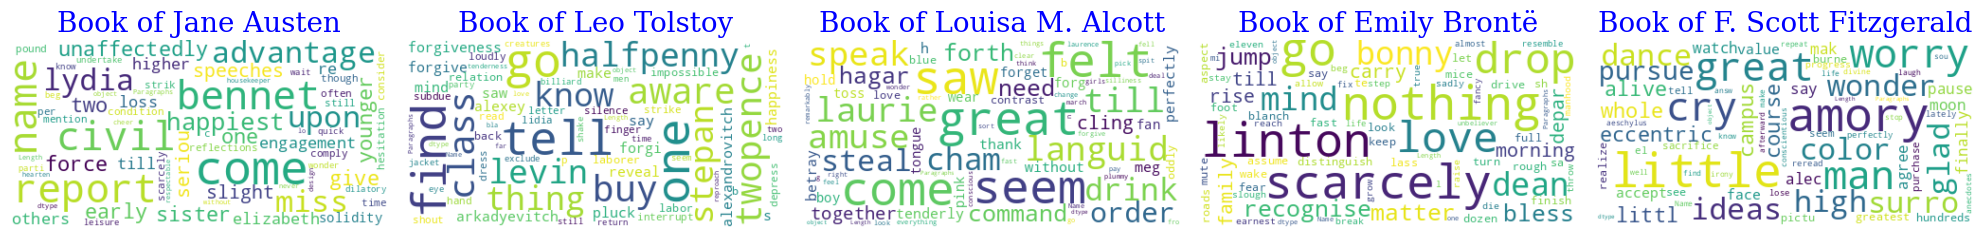

In [11]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

# Generate a wordcloud
indx = 199

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))

for i, ax in enumerate(axes.flatten()):
    wc.generate(str(df[(indx - 200) + 1: indx]["Paragraphs"]))
    ax.imshow(wc, interpolation="bilinear")
    title = "Book of {}".format(str(df.loc[indx]["Author"]))
    font1 = {'family': 'serif', 'color': 'blue', 'size': 20}
    ax.set_title(title, fontdict=font1)
    ax.axis('off')
    indx += 200

plt.tight_layout()
plt.show()

<Axes: xlabel='Author', ylabel='count'>

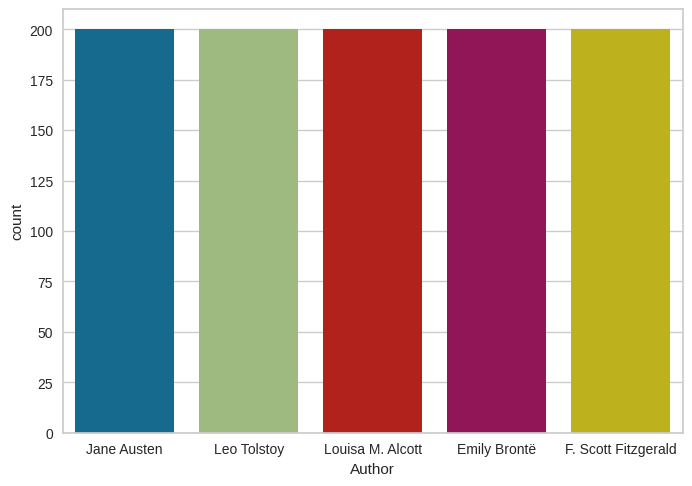

In [12]:
sns.countplot(x=df['Author'])

In [13]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1,1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


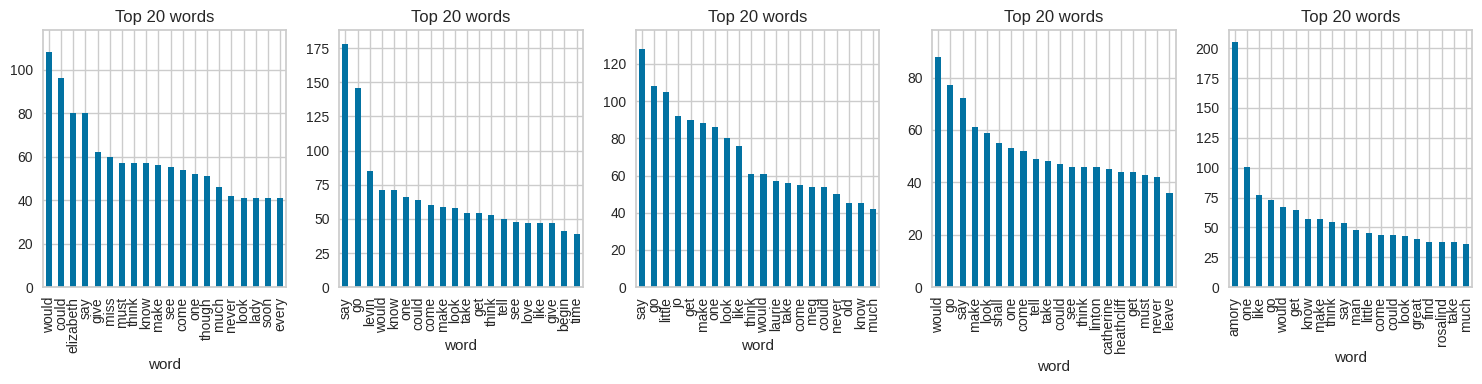

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

indx = 199

fig, axs = plt.subplots(1, 5, figsize=(15, 4))  # Create a figure with 1 row and 5 columns

for i in range(5):
    common_words = get_top_n_words(df[(indx - 200) + 1: indx]["Paragraphs"], 20)

    df1 = pd.DataFrame(common_words, columns=['word', 'count'])
    ax = axs[i]  # Select the appropriate subplot
    df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 words', ax=ax)
    ax.set_ylim([0, df1['count'].max() + 10])  # Set y-axis limits to ensure consistent scaling
    indx += 200

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


### Transformation

In [15]:
def plot_TSNE(data,labels):
    tsne = TSNEVisualizer()
    tsne.fit(data,labels)
    plt.xlabel("TSNE x")
    plt.ylabel("TSNE y")
    tsne.show()

In [16]:
#BOW
def BOW():
    cv = CountVectorizer()
    cv_matrix = cv.fit_transform(df['Paragraphs'])
    cv_matrix = cv_matrix.toarray()
    # get all unique words in the corpus
    vocab = cv.get_feature_names_out()
    # show document feature vectors
    data = pd.DataFrame(cv_matrix, columns=vocab)
    return data

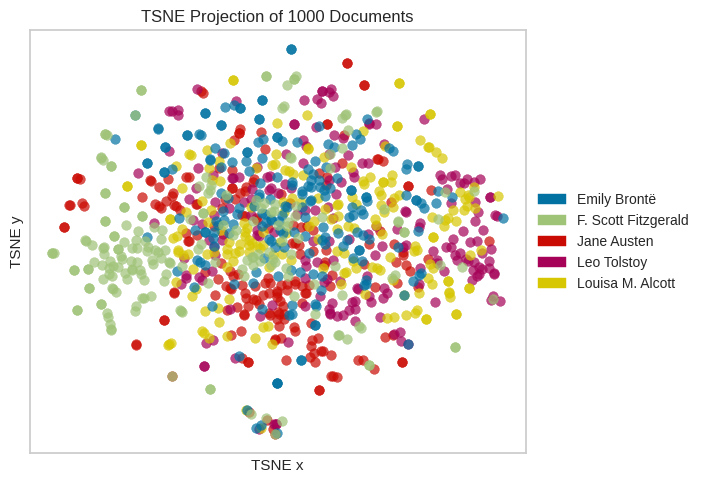

In [17]:
plot_TSNE(BOW(),df['Author'])

In [18]:
#TF-IDF
def TFIDF():
    tv = TfidfVectorizer()
    tv_matrix = tv.fit_transform(df['Paragraphs'])
    tv_matrix = tv_matrix.toarray()
    vocab = tv.get_feature_names_out()
    data = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
    return data

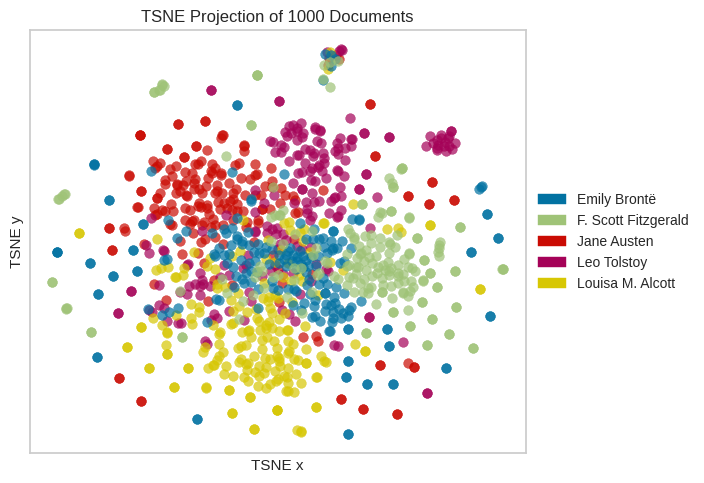

In [19]:
plot_TSNE(TFIDF(),df['Author'])

In [20]:
#N-gram
def Ngram():
    bv = CountVectorizer(ngram_range=(2, 2))
    bv_matrix = bv.fit_transform(df['Paragraphs'])
    bv_matrix = bv_matrix.toarray()
    vocab = bv.get_feature_names_out()
    data = pd.DataFrame(bv_matrix, columns=vocab)
    return data

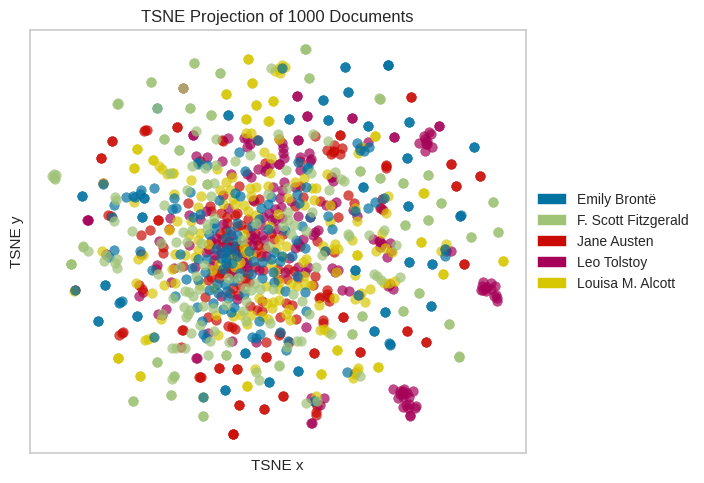

In [21]:
plot_TSNE(Ngram(),df['Author'])

### Modeling

In [22]:
def plot_multilabel_confusion_matrices(confusion_matrices, labels):
    num_classes = len(labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))

    for i, ax in enumerate(axes):
        # Normalize the confusion matrix if needed
        confusion_matrix = confusion_matrices[i].astype('float') / confusion_matrices[i].sum(axis=1)[:, np.newaxis]

        # Plotting the confusion matrix as a heatmap
        ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title("Confusion Matrix - Class {}".format(labels[i]))
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])

        # Adding text annotations in each cell
        thresh = confusion_matrix.max() / 2.0
        for j in range(confusion_matrix.shape[0]):
            for k in range(confusion_matrix.shape[1]):
                ax.text(k, j, "{:.2f}".format(confusion_matrix[j, k]),
                         horizontalalignment="center",
                         color="white" if confusion_matrix[j, k] > thresh else "black")

        ax.grid(False)  # Remove the grid

    plt.tight_layout()
    plt.show()


In [23]:
def plot_cros_valid_result(train_score,val_score):
    X_axis = np.arange(len(val_score))
    plt.bar(X_axis-0.2, val_score, 0.4, color='blue', label='Validation')
    plt.bar(X_axis+0.2, train_score, 0.4, color='red', label='Training')
    plt.legend(["Validation", "Training"],loc='best')
    plt.show()

In [24]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [25]:
def encode_label():
  # Assuming you have a DataFrame 'df' with a target column named 'Author'
  y = df['Author']
  # Create an instance of the LabelEncoder
  label_encoder = LabelEncoder()
  # Fit and transform the target variable
  y_encoded = label_encoder.fit_transform(y)
  return y_encoded

In [26]:
def Data_split(data, labels):
  SEED=123
  X = data
  y = labels
  X_train,X_test,y_train,y_test=train_test_split(X, y, test_size = 0.2, random_state=SEED, stratify=y)
  return X_train,X_test,y_train,y_test

In [27]:
from sklearn.metrics import classification_report

def train_and_evaluate_models(data, labels):
    X_train, X_test, y_train, y_test = Data_split(data, labels)
    models = {
        "SVM": svm.SVC(probability=True),
        "Random Forest": ensemble.RandomForestClassifier(),
        "Naïve Bayes": naive_bayes.GaussianNB(),
        "k-Nearest Neighbor": neighbors.KNeighborsClassifier(n_neighbors=5),
        "XG-Boost": xgb.XGBClassifier(),
        "Logistic Regression": LogisticRegression()
    }
    
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    best_accuracy = 0.0
    best_model_name = ""

    for model_name, model in models.items():
        scores = cross_validate(estimator=model, X=X_train, y=y_train, cv=cv, scoring=['accuracy'], return_train_score=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = model_name
        
        print('Cross Validation accuracy scores: %s' % scores['test_accuracy'])
        print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
        print(f"{model_name} Accuracy: {accuracy}")
        print("" * 10, "" * 10)
        y_unique = np.unique(np.array(y_test))
        mcm = multilabel_confusion_matrix(y_test, y_pred, labels=y_unique)
        plot_cros_valid_result(scores["train_accuracy"], scores["test_accuracy"])
        print("" * 10, "" * 10)
        plot_multilabel_confusion_matrices(mcm, y_unique)
        print("" * 10, "" * 10)
        plot_multiclass_roc(model, X_test, y_test, n_classes=len(y_unique))
        print("" * 10, "" * 10)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("" * 10, "" * 10)
    
    print("Best Model: {} with Accuracy: {}".format(best_model_name, best_accuracy))

Cross Validation accuracy scores: [0.8375 0.9    0.8625 0.825  0.85   0.875  0.9375 0.8875 0.8875 0.875 ]
Cross Validation accuracy: 0.874 +/- 0.031
SVM Accuracy: 0.87
 


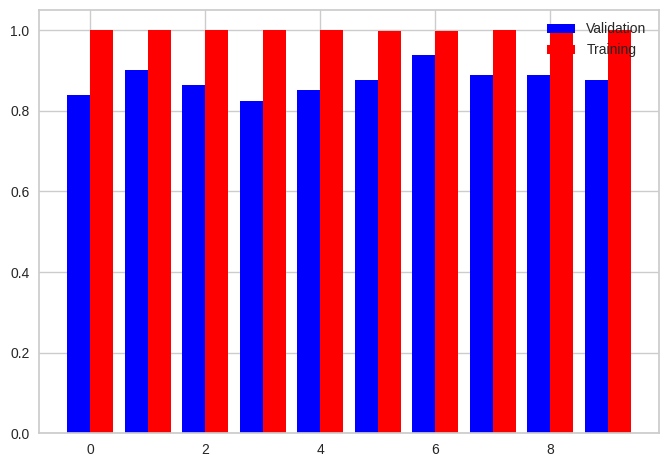

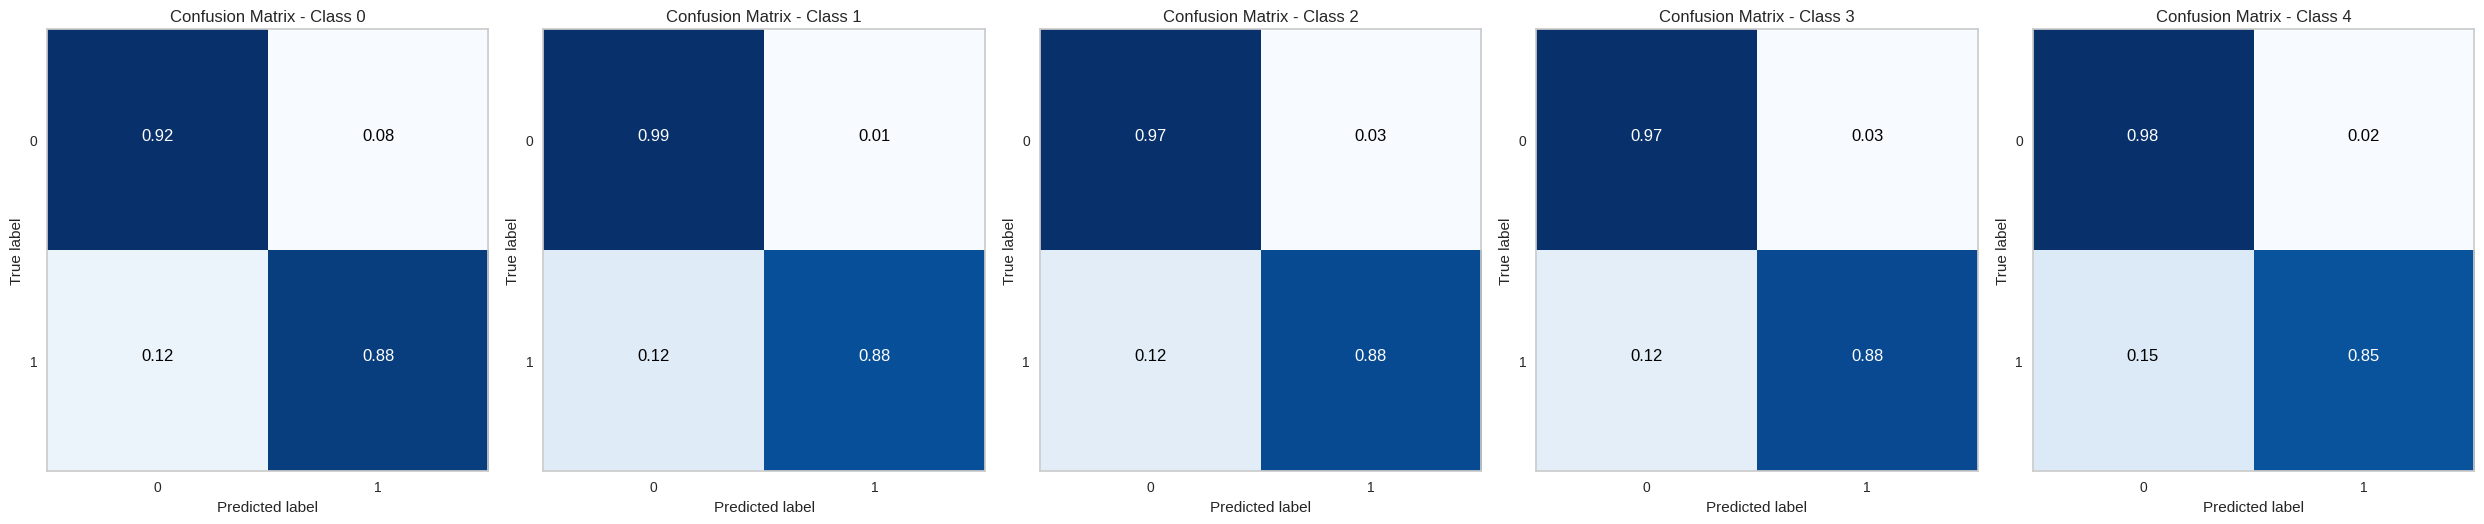

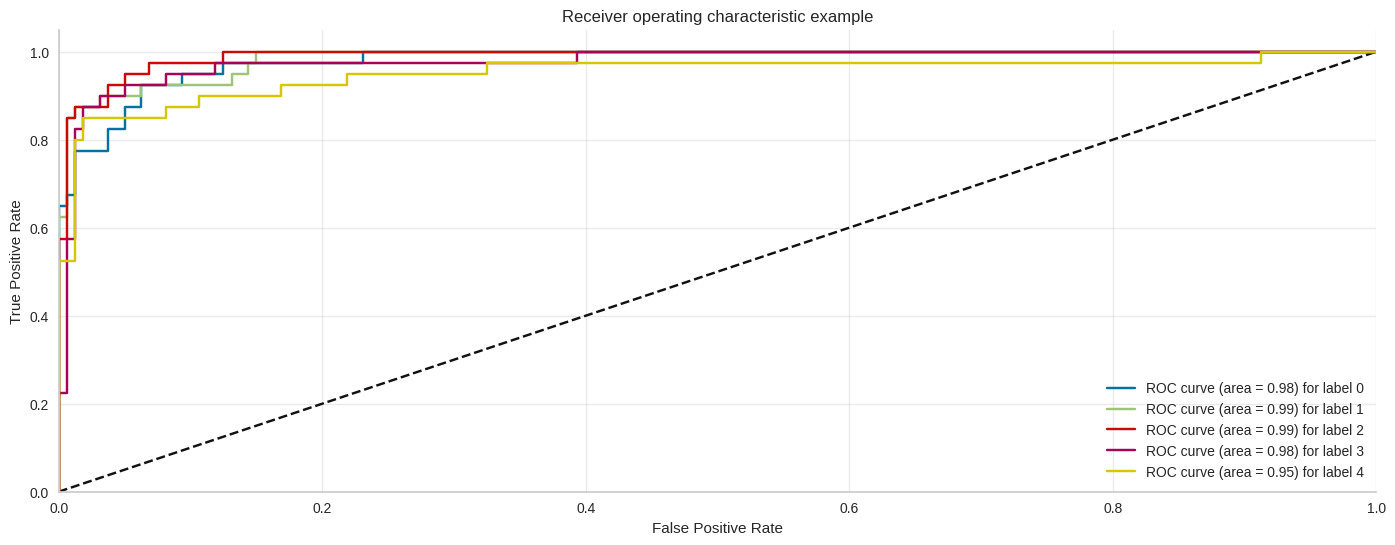

 
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80        40
           1       0.97      0.88      0.92        40
           2       0.90      0.88      0.89        40
           3       0.88      0.88      0.88        40
           4       0.92      0.85      0.88        40

    accuracy                           0.87       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.88      0.87      0.87       200

 
Cross Validation accuracy scores: [0.875  0.9    0.85   0.75   0.8625 0.95   0.9    0.8875 0.9375 0.8875]
Cross Validation accuracy: 0.880 +/- 0.052
Random Forest Accuracy: 0.855
 


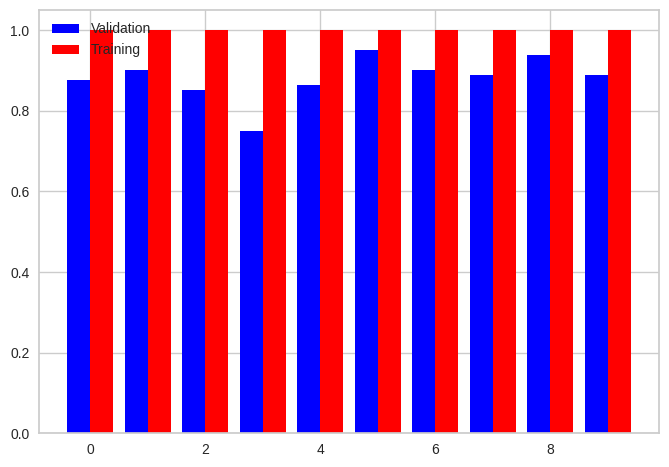

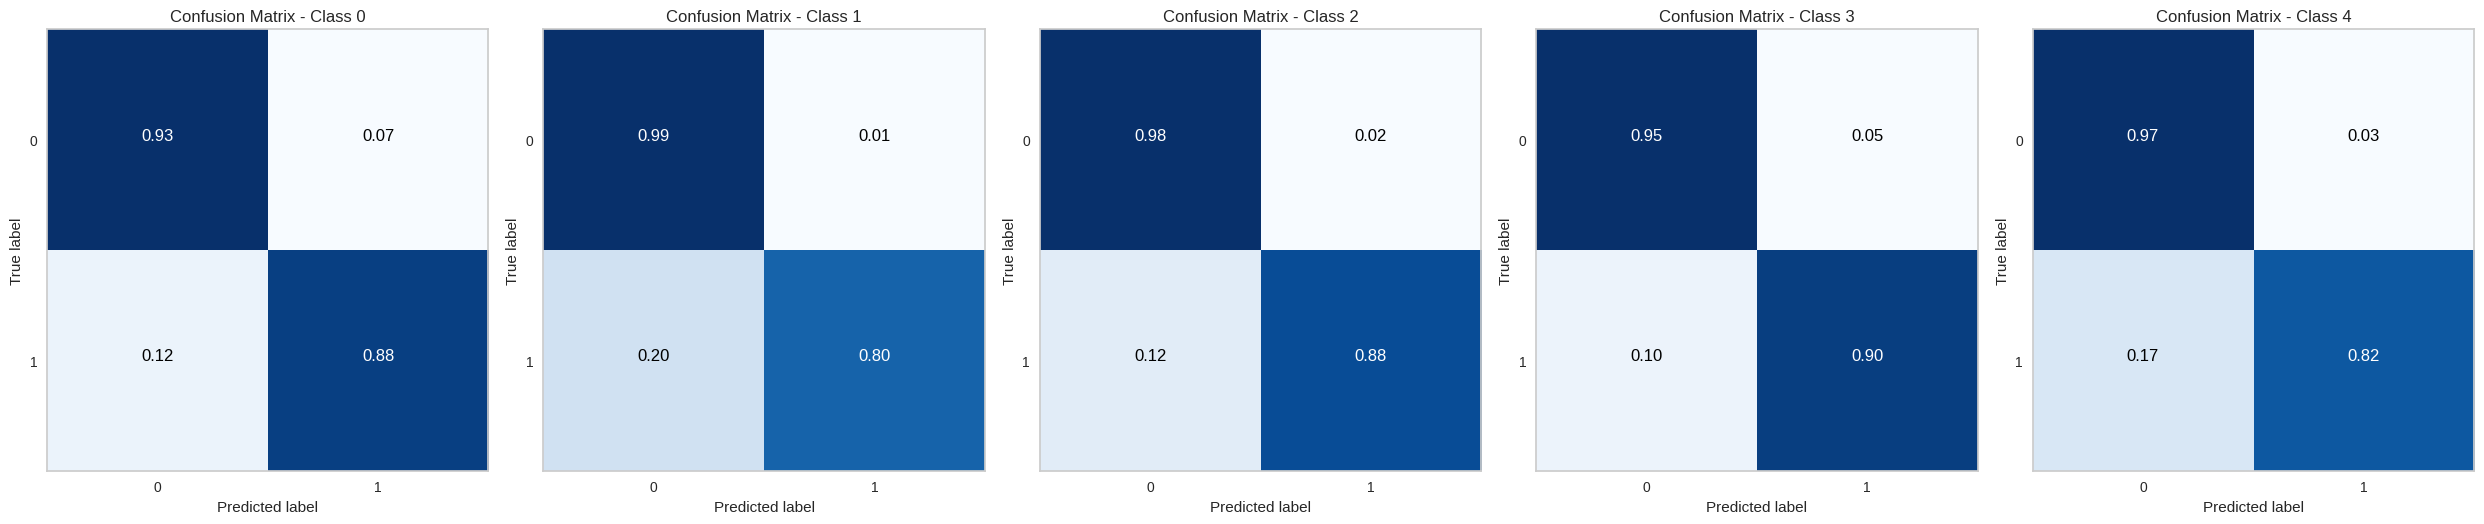

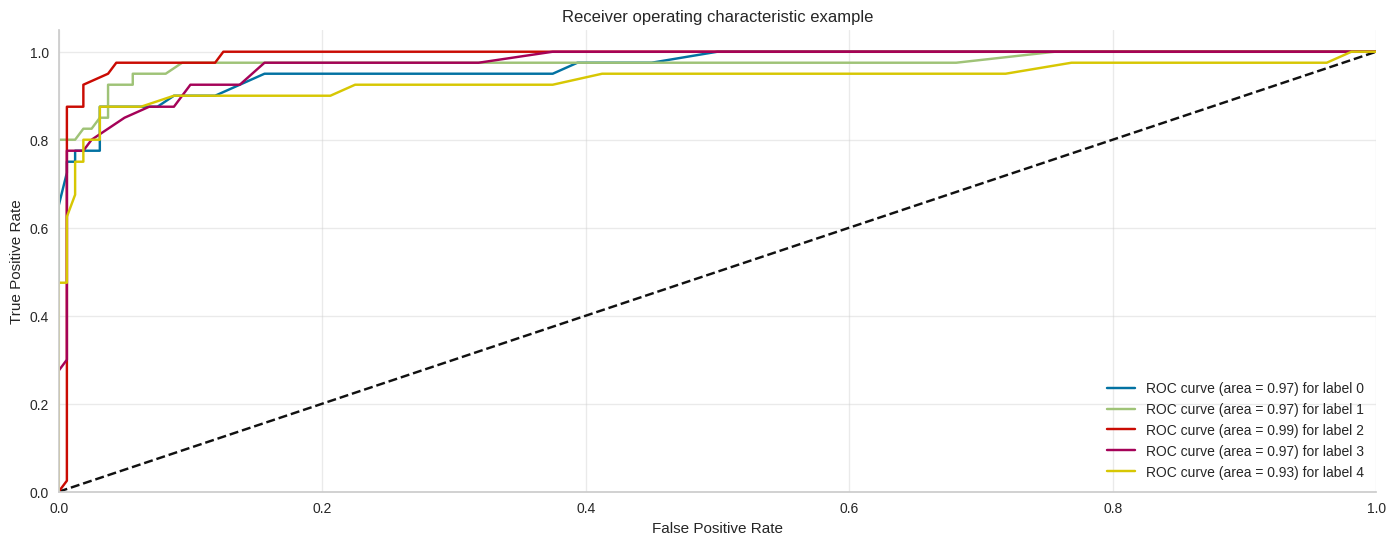

 
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        40
           1       0.97      0.80      0.88        40
           2       0.92      0.88      0.90        40
           3       0.82      0.90      0.86        40
           4       0.87      0.82      0.85        40

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.86       200
weighted avg       0.86      0.85      0.86       200

 
Cross Validation accuracy scores: [0.8    0.85   0.7875 0.8375 0.8375 0.8375 0.925  0.925  0.8375 0.9125]
Cross Validation accuracy: 0.855 +/- 0.047
Naïve Bayes Accuracy: 0.85
 


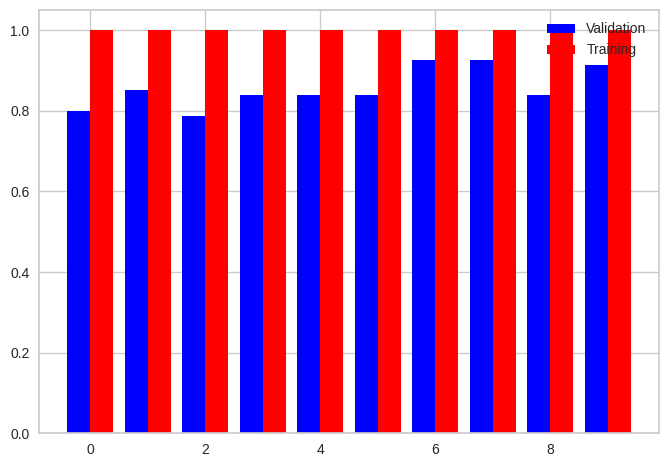

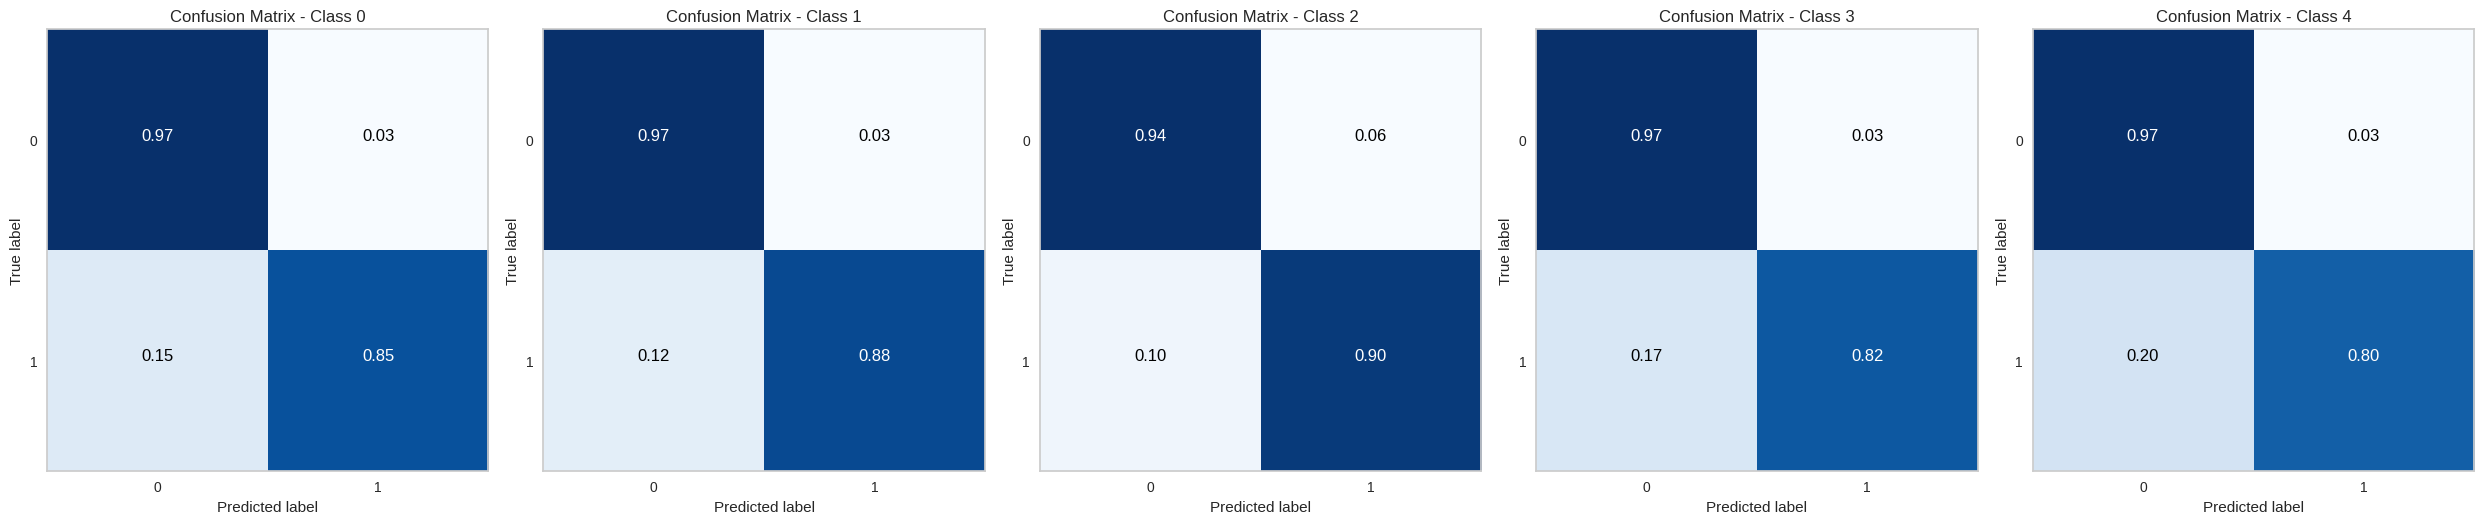

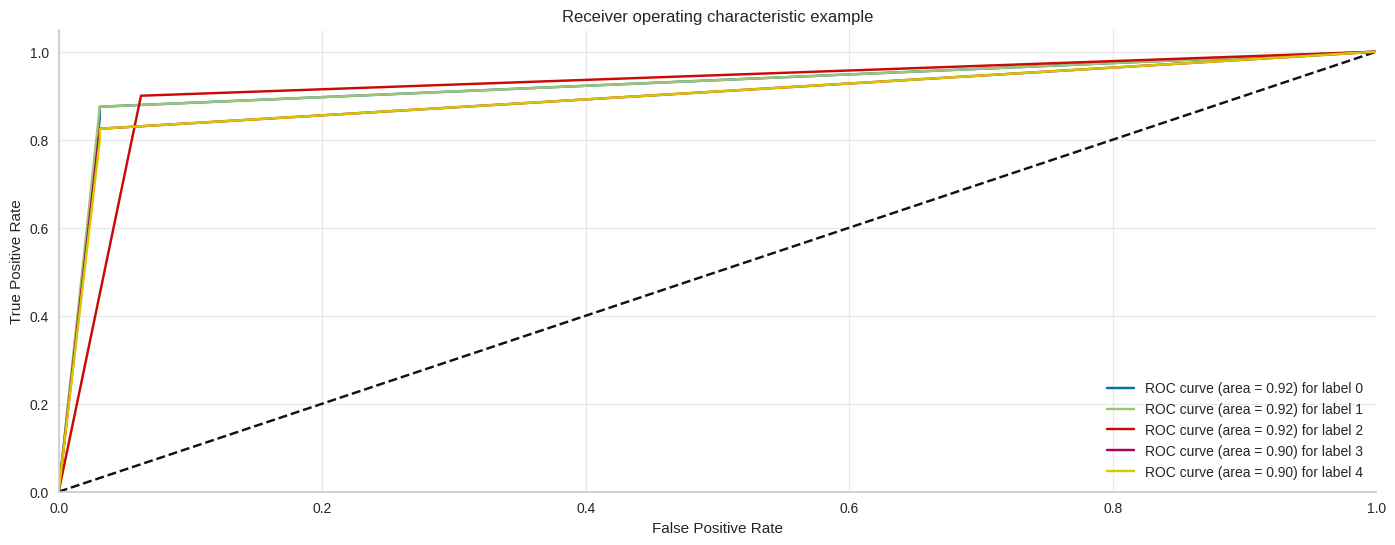

 
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.88      0.88      0.88        40
           2       0.78      0.90      0.84        40
           3       0.87      0.82      0.85        40
           4       0.86      0.80      0.83        40

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200

 
Cross Validation accuracy scores: [0.45   0.4125 0.45   0.475  0.45   0.5375 0.525  0.475  0.5625 0.35  ]
Cross Validation accuracy: 0.469 +/- 0.059
k-Nearest Neighbor Accuracy: 0.545
 


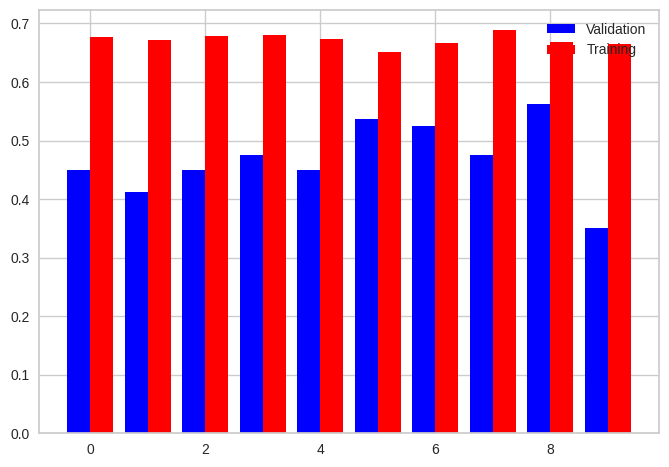

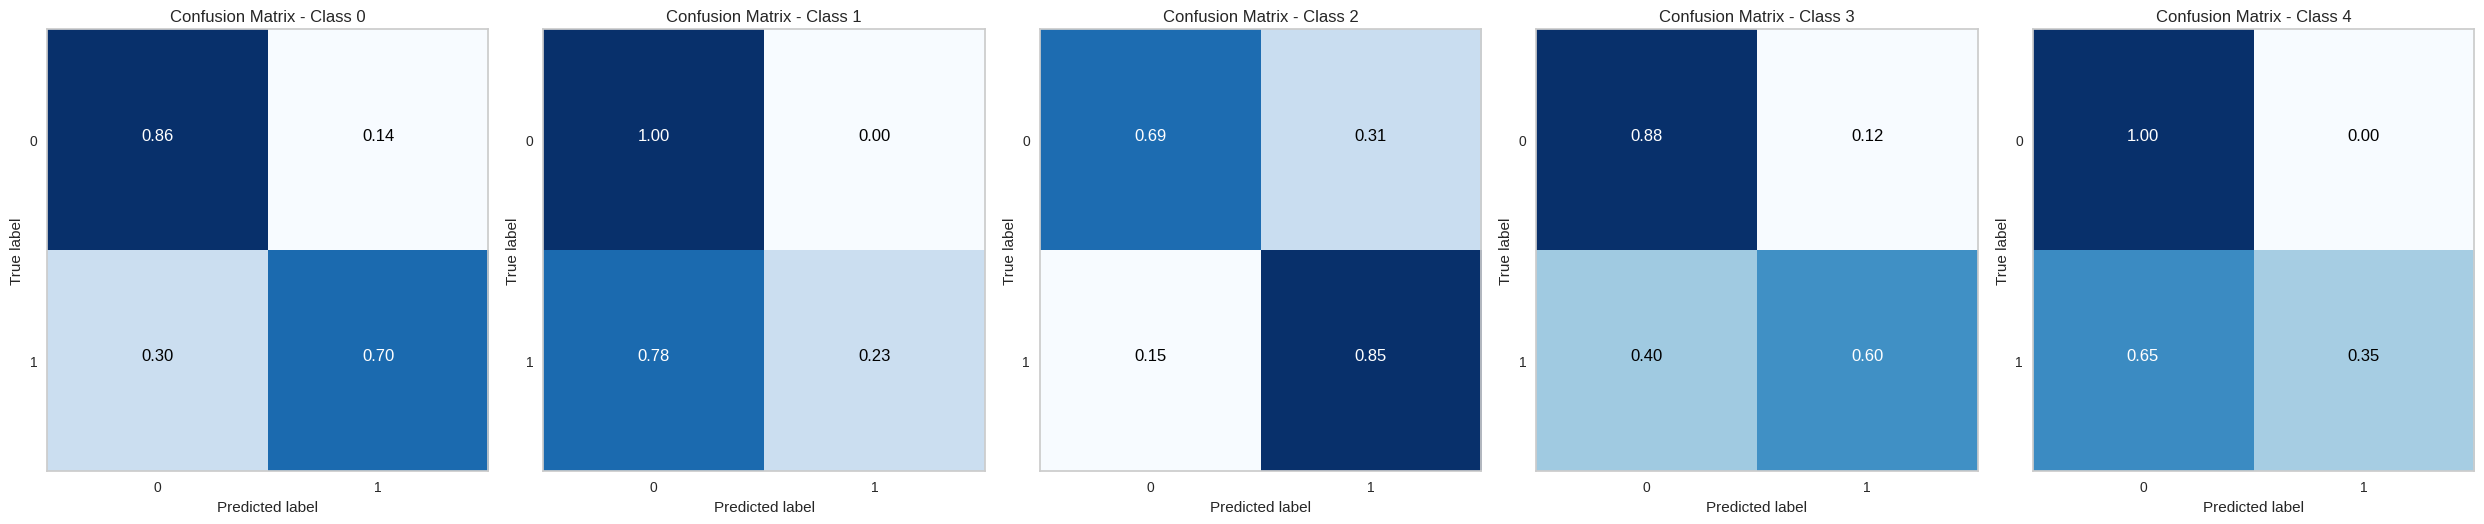

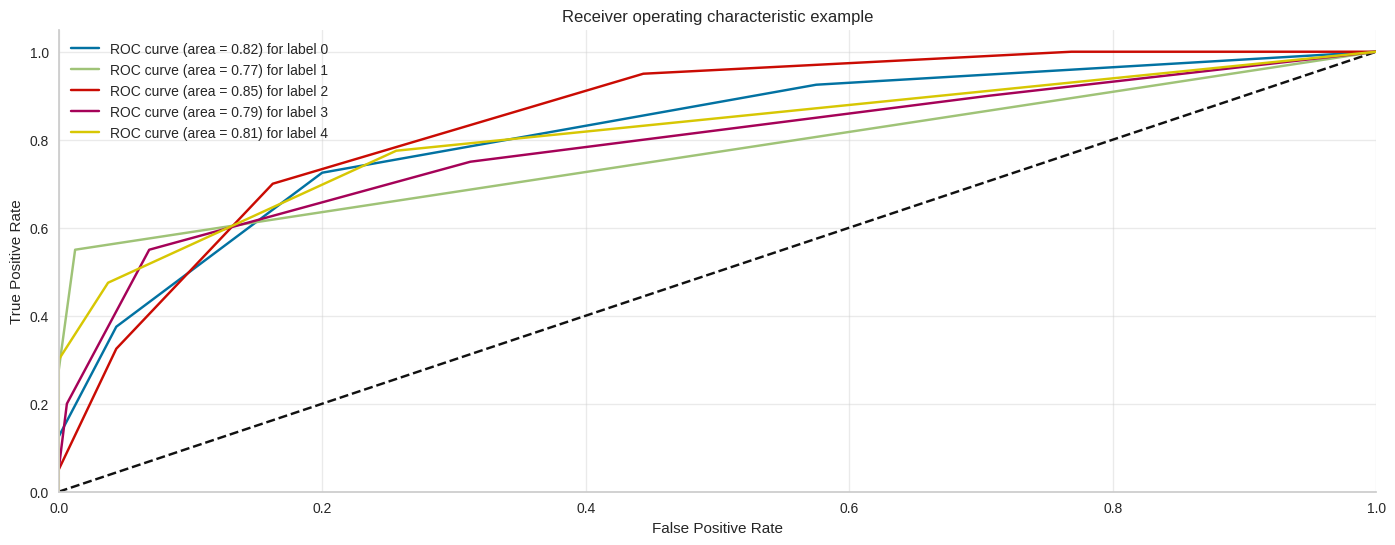

 
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.70      0.62        40
           1       1.00      0.23      0.37        40
           2       0.40      0.85      0.55        40
           3       0.56      0.60      0.58        40
           4       1.00      0.35      0.52        40

    accuracy                           0.55       200
   macro avg       0.70      0.55      0.53       200
weighted avg       0.70      0.55      0.53       200

 
Cross Validation accuracy scores: [0.8    0.85   0.8125 0.7375 0.8625 0.9    0.9125 0.8125 0.8875 0.875 ]
Cross Validation accuracy: 0.845 +/- 0.051
XG-Boost Accuracy: 0.845
 


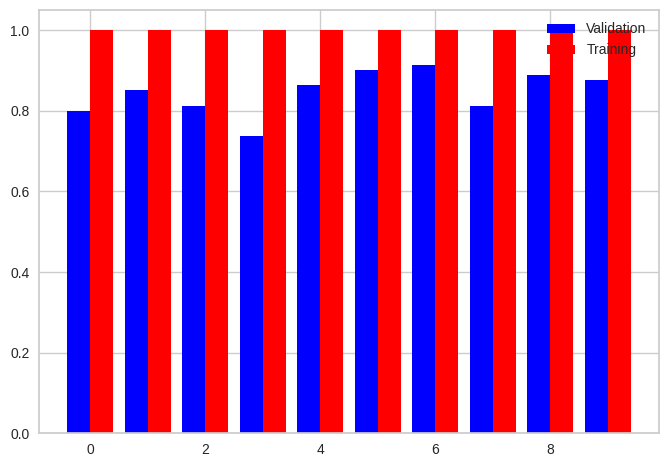

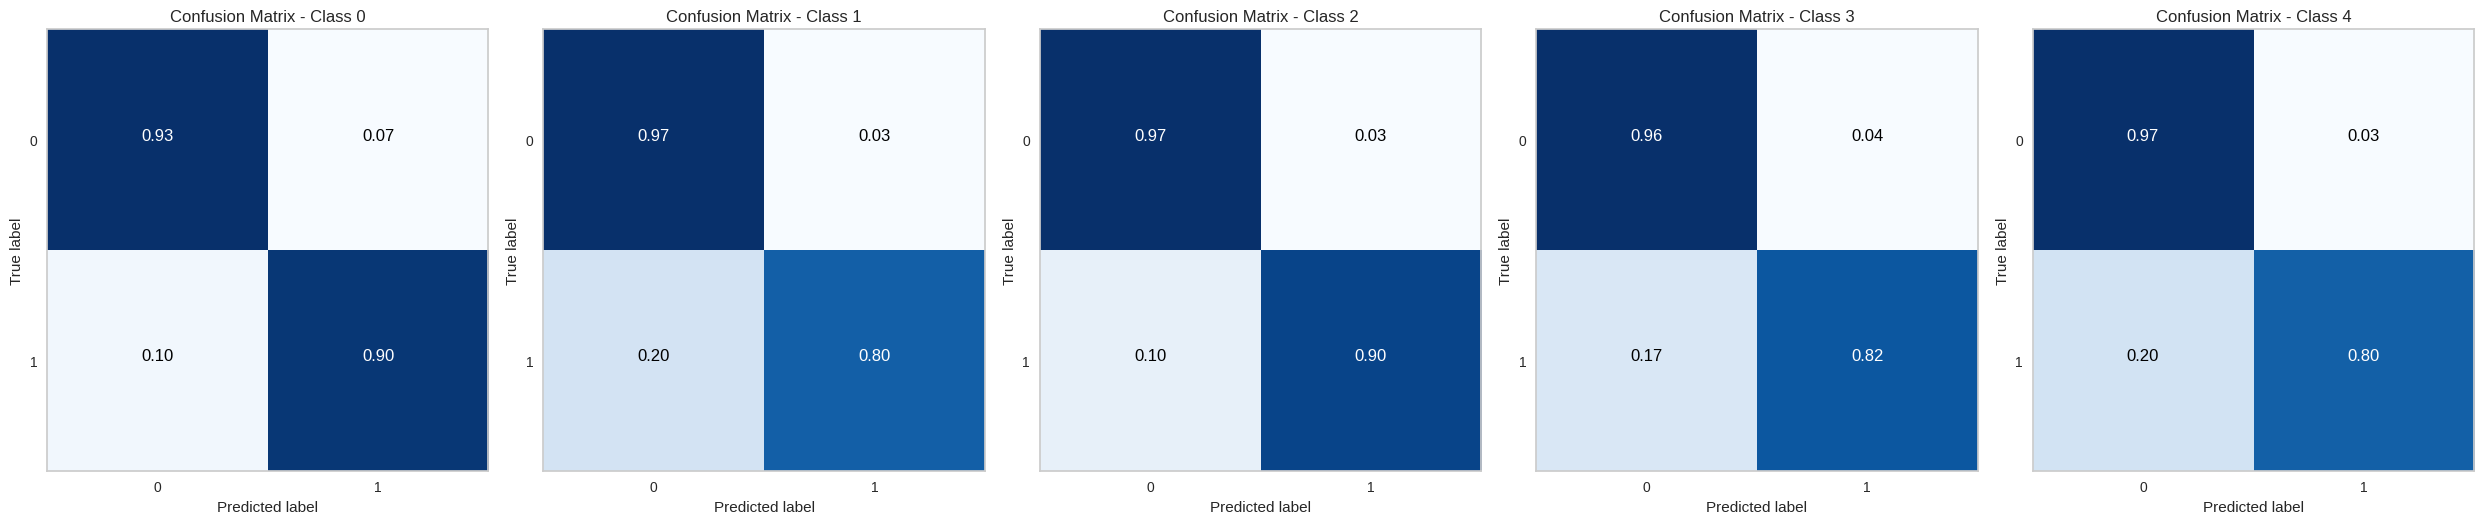

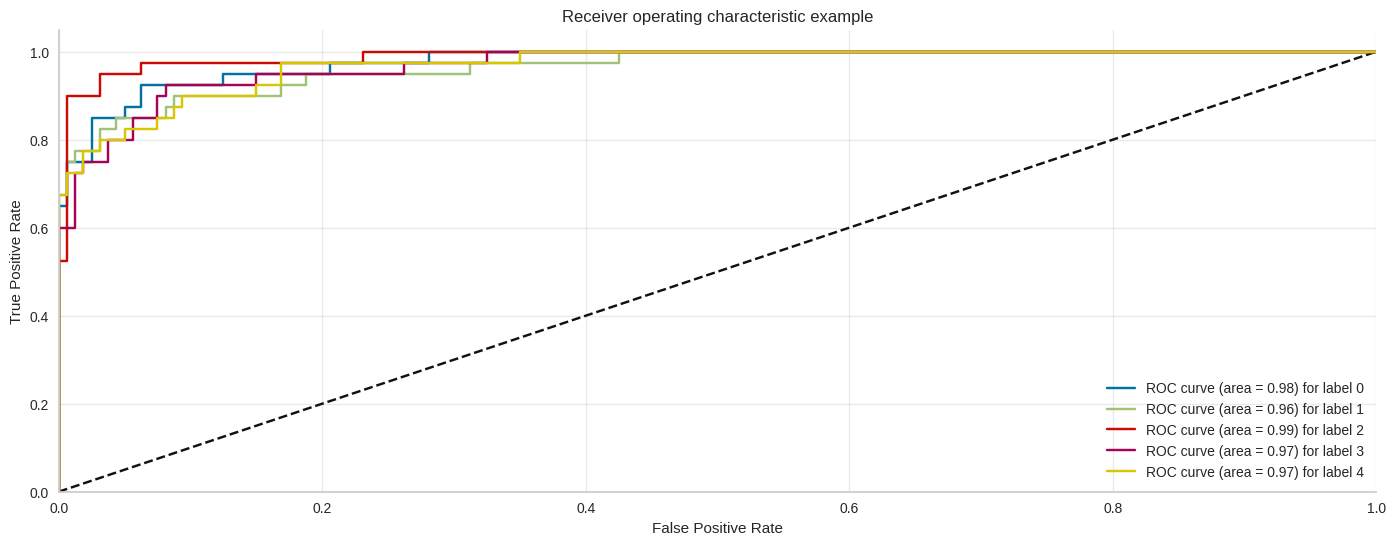

 
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        40
           1       0.86      0.80      0.83        40
           2       0.90      0.90      0.90        40
           3       0.85      0.82      0.84        40
           4       0.89      0.80      0.84        40

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.85       200
weighted avg       0.85      0.84      0.85       200

 
Cross Validation accuracy scores: [0.9    0.9    0.8625 0.8375 0.8875 0.9125 0.9625 0.925  0.9125 0.9375]
Cross Validation accuracy: 0.904 +/- 0.034
Logistic Regression Accuracy: 0.875
 


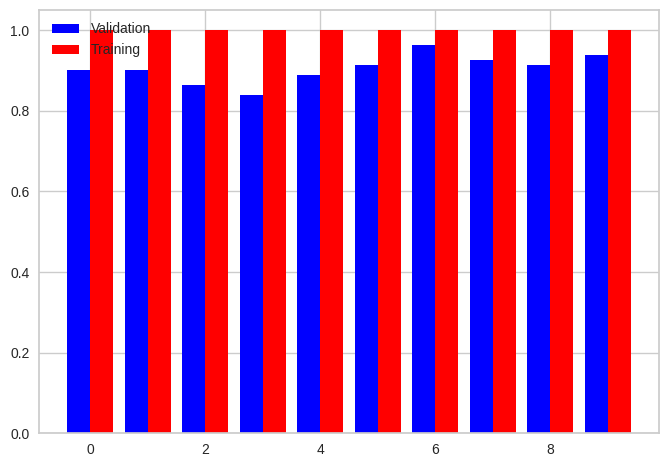

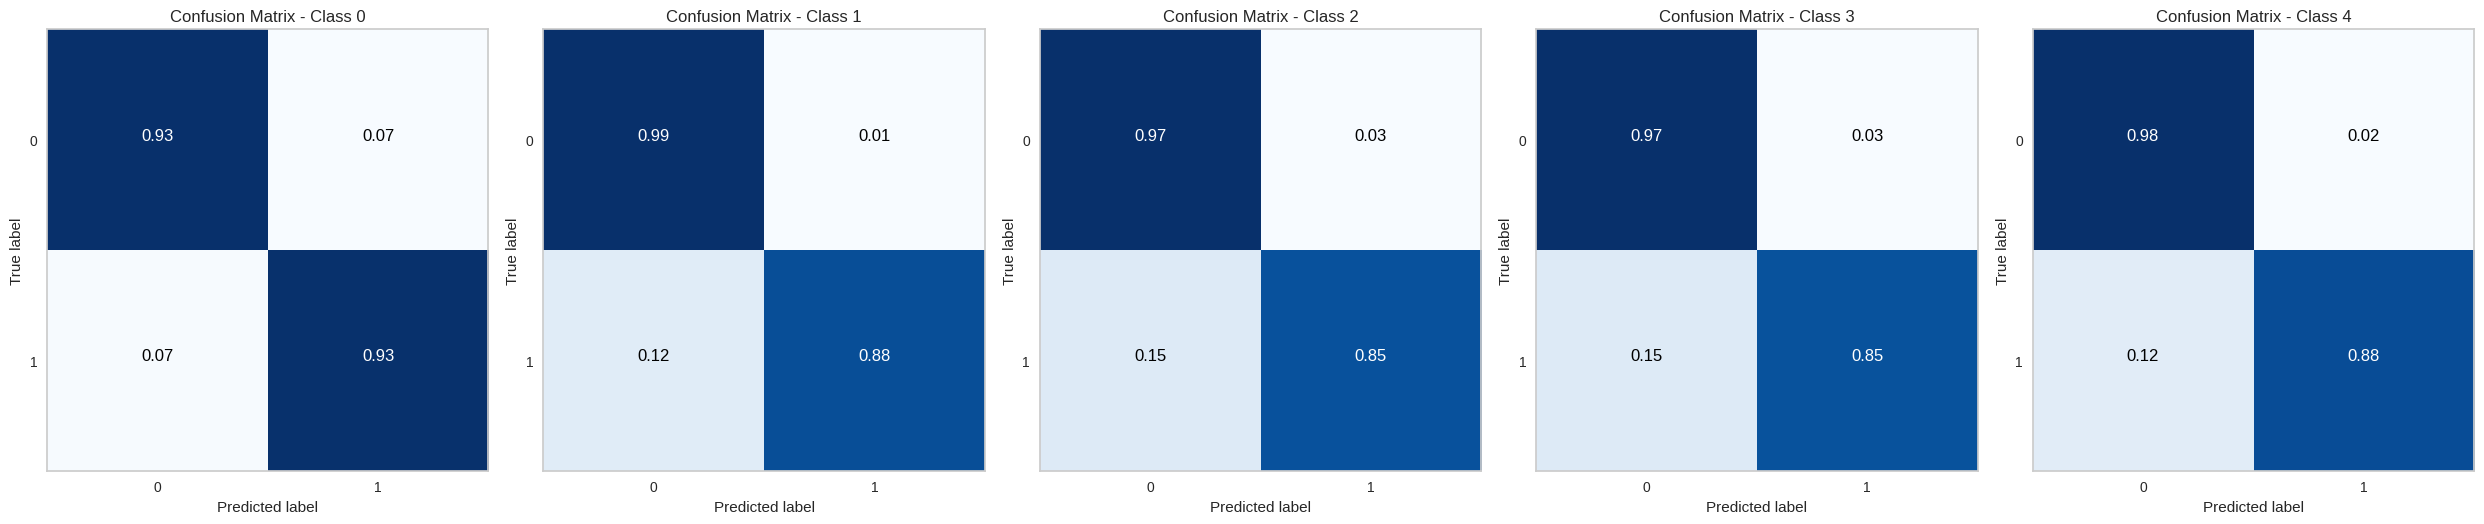

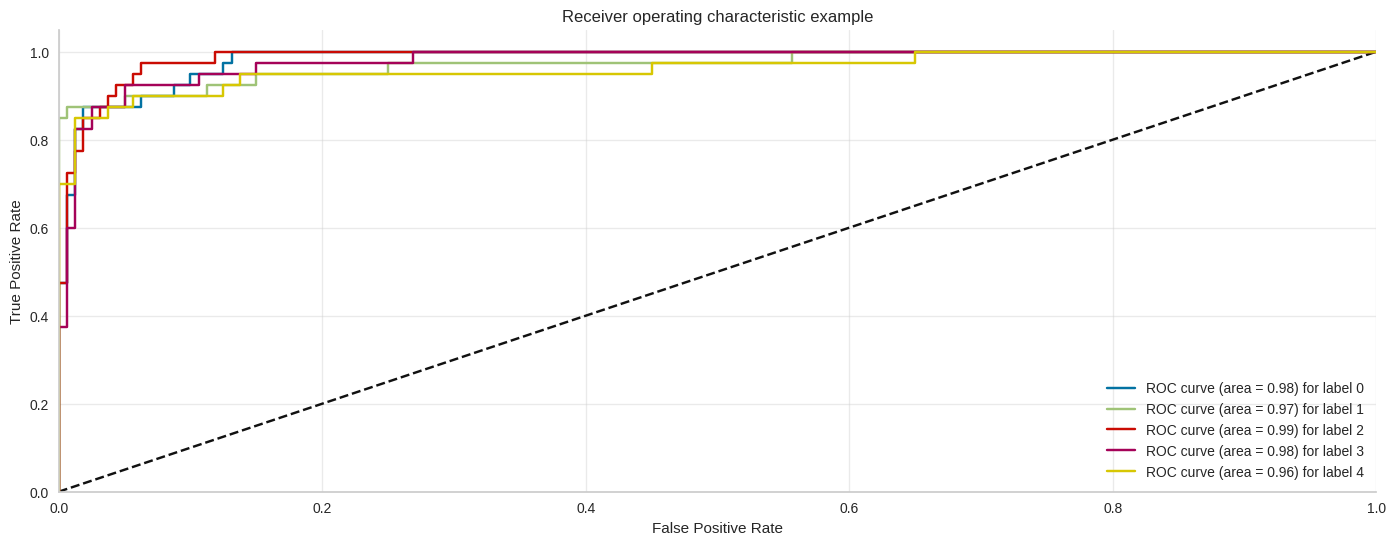

 
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        40
           1       0.95      0.88      0.91        40
           2       0.87      0.85      0.86        40
           3       0.89      0.85      0.87        40
           4       0.92      0.88      0.90        40

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200

 
Best Model: Logistic Regression with Accuracy: 0.875


In [28]:
Transformed_Data = BOW()
labels = encode_label()
train_and_evaluate_models(Transformed_Data, labels)

Cross Validation accuracy scores: [0.9125 0.925  0.925  0.85   0.95   0.925  0.9875 0.9625 0.9375 0.95  ]
Cross Validation accuracy: 0.932 +/- 0.035
SVM Accuracy: 0.9
 


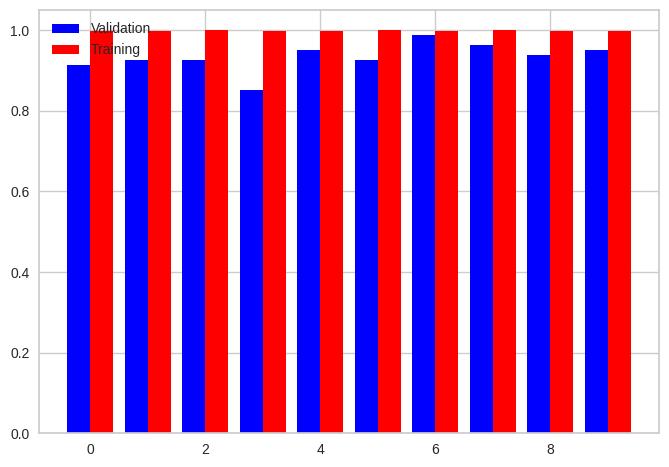

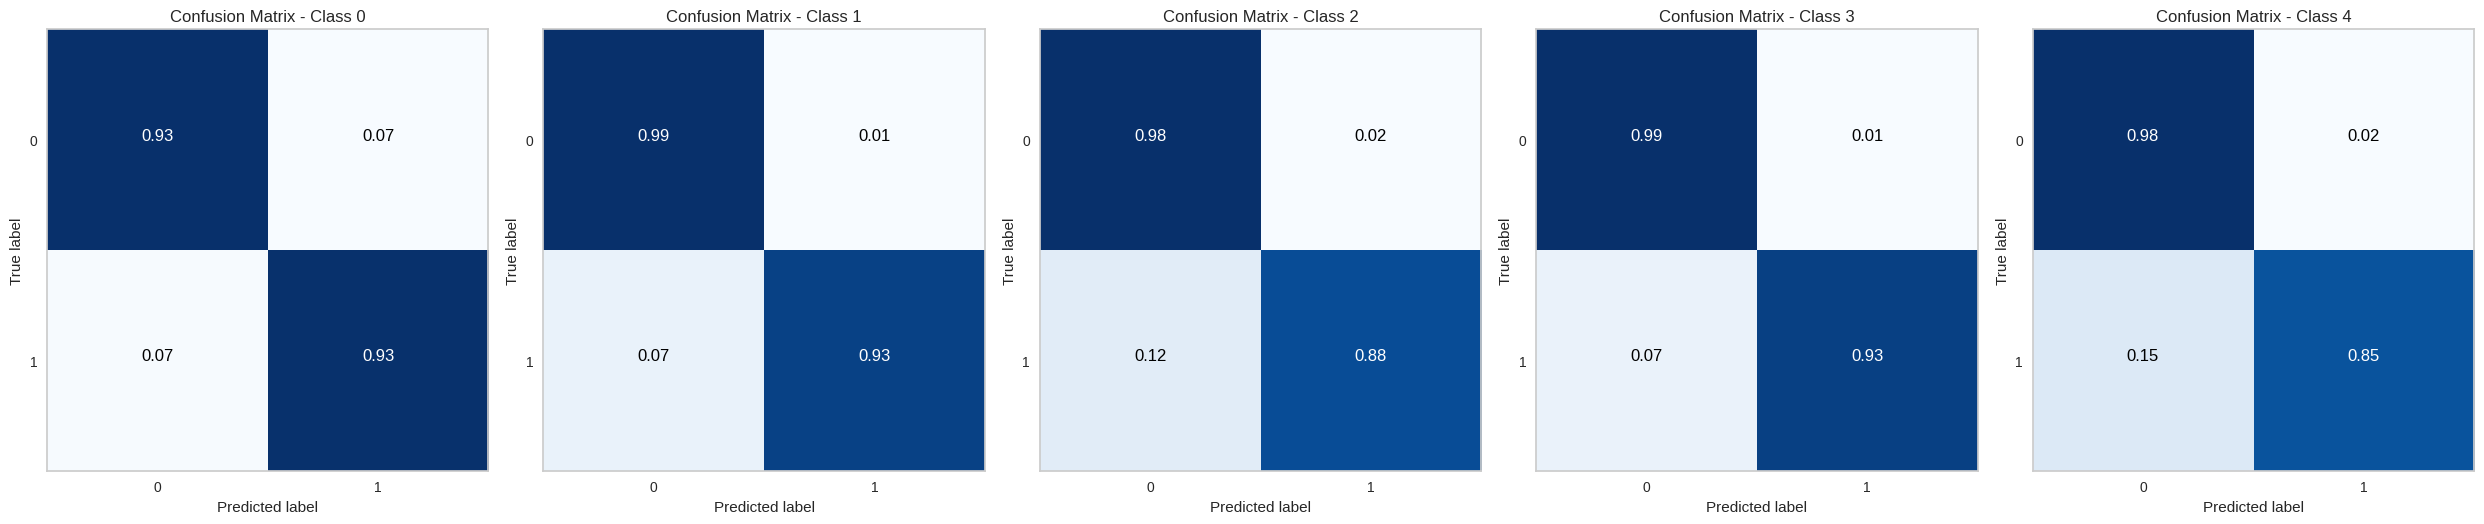

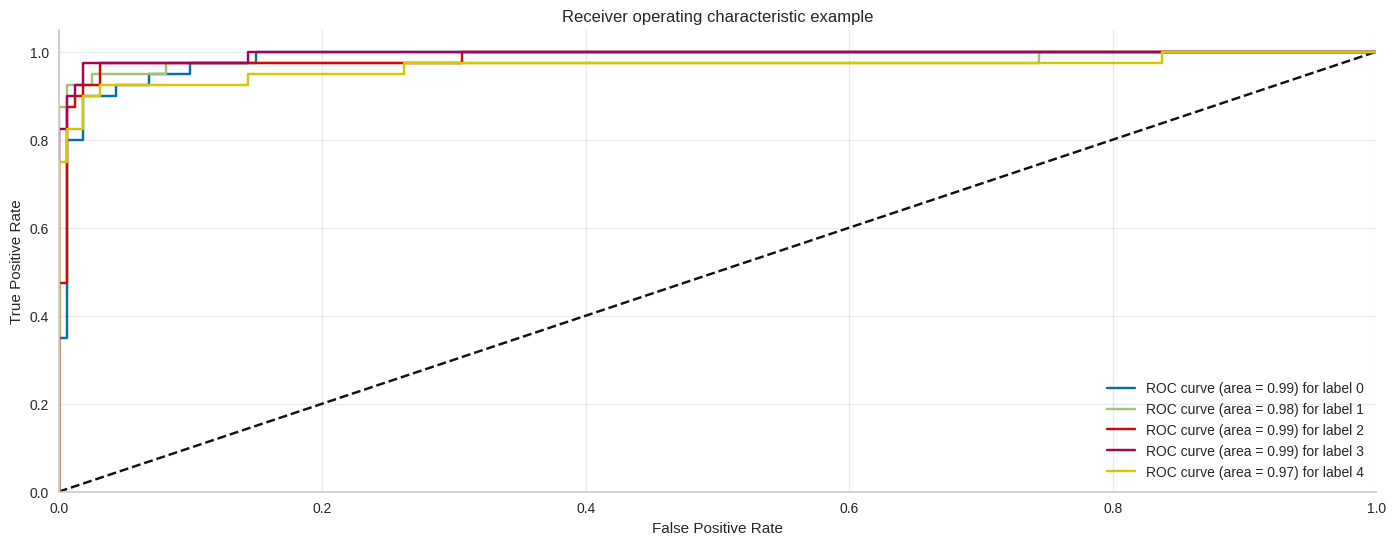

 
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        40
           1       0.97      0.93      0.95        40
           2       0.92      0.88      0.90        40
           3       0.95      0.93      0.94        40
           4       0.92      0.85      0.88        40

    accuracy                           0.90       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.91      0.90      0.90       200

 
Cross Validation accuracy scores: [0.8625 0.925  0.8875 0.75   0.9125 0.9125 0.9    0.8625 0.95   0.9   ]
Cross Validation accuracy: 0.886 +/- 0.052
Random Forest Accuracy: 0.89
 


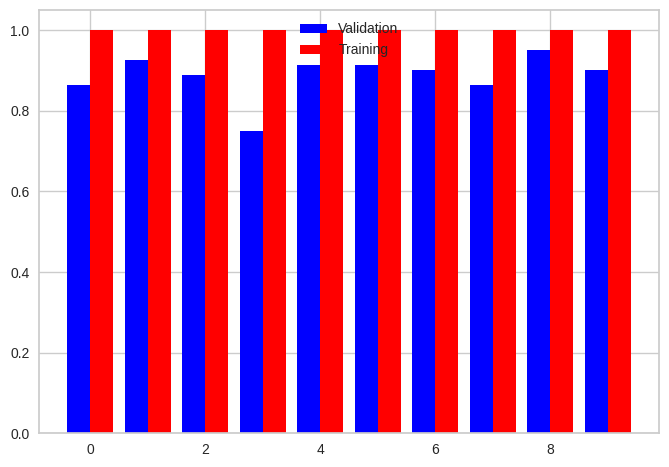

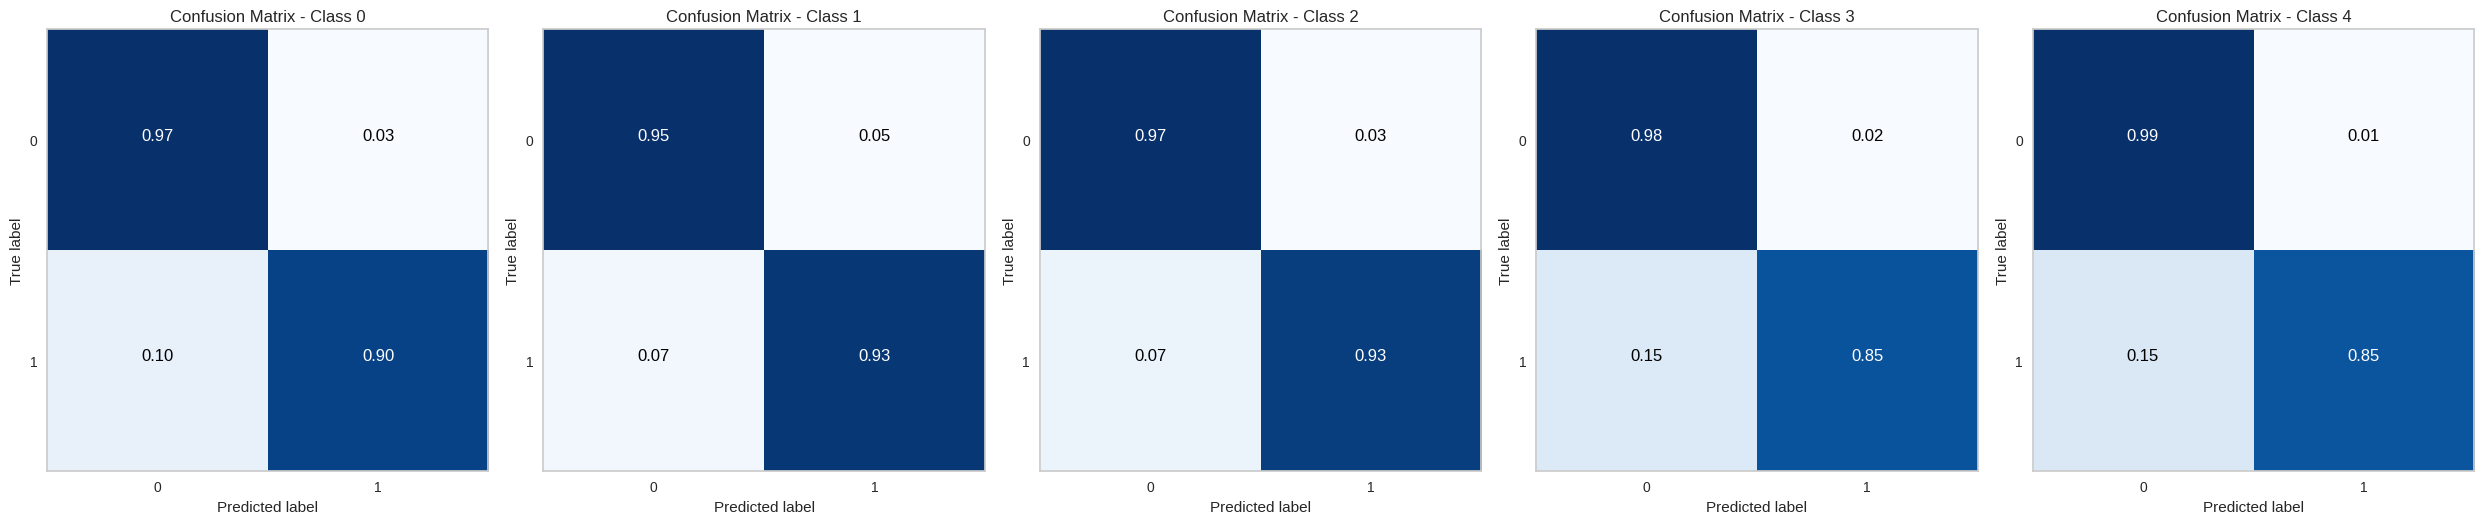

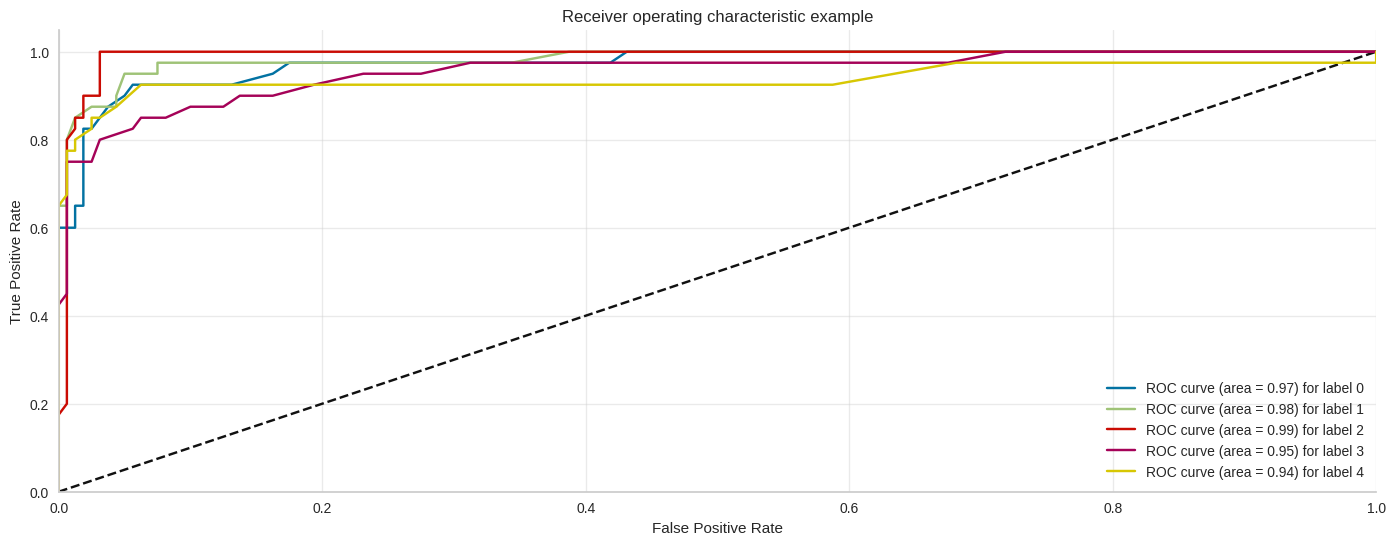

 
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        40
           1       0.82      0.93      0.87        40
           2       0.90      0.93      0.91        40
           3       0.92      0.85      0.88        40
           4       0.94      0.85      0.89        40

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

 
Cross Validation accuracy scores: [0.8    0.7625 0.775  0.8375 0.8    0.825  0.8625 0.9    0.825  0.875 ]
Cross Validation accuracy: 0.826 +/- 0.042
Naïve Bayes Accuracy: 0.805
 


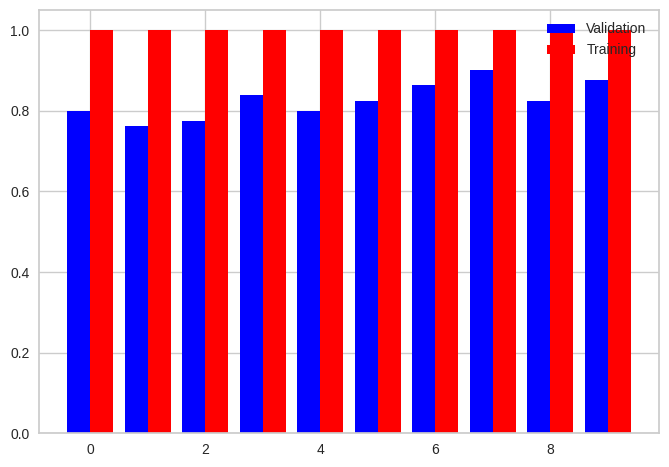

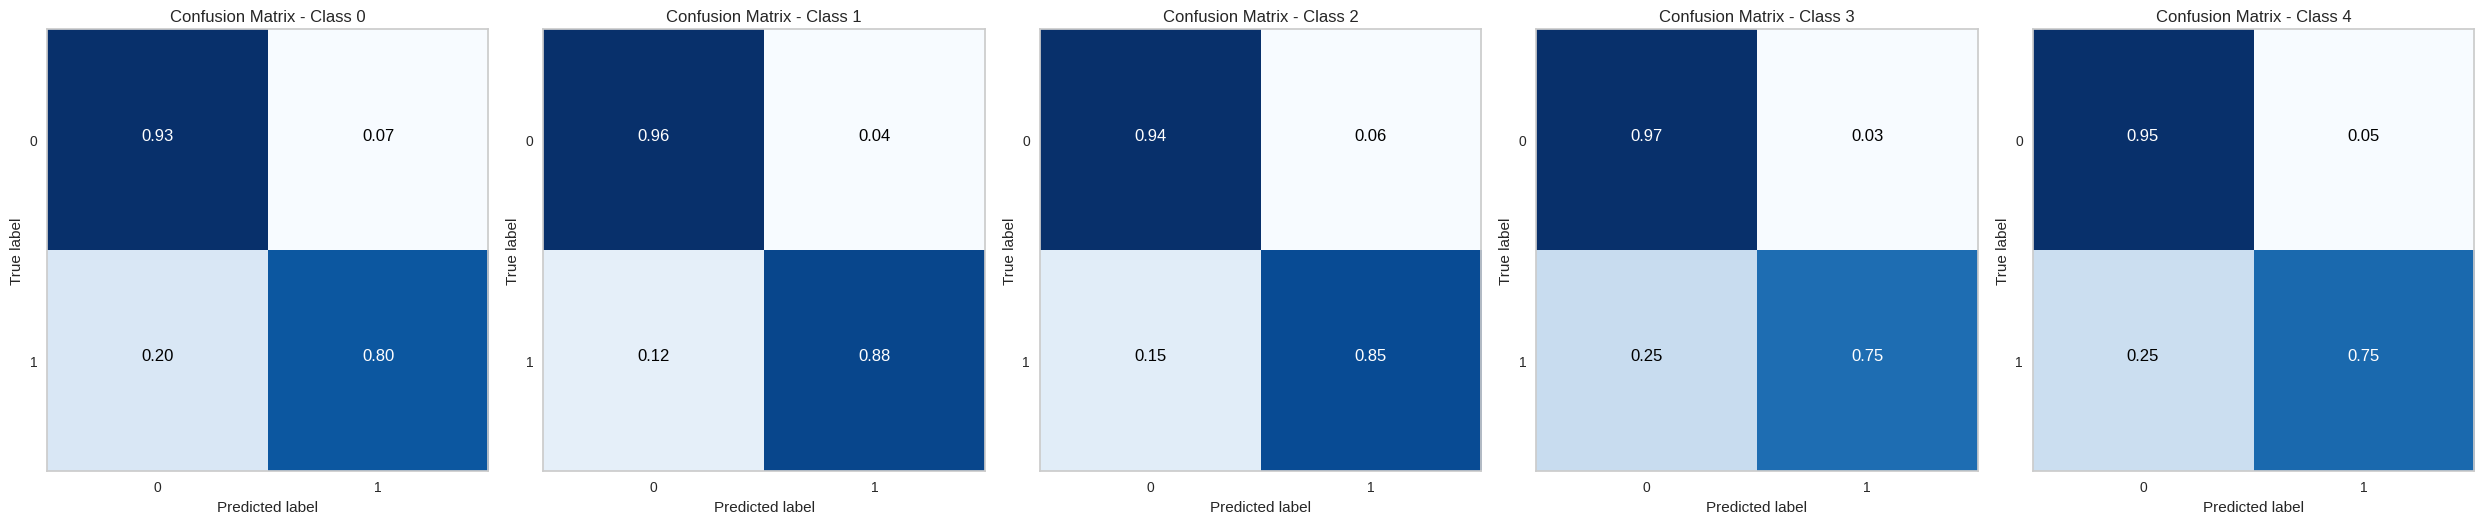

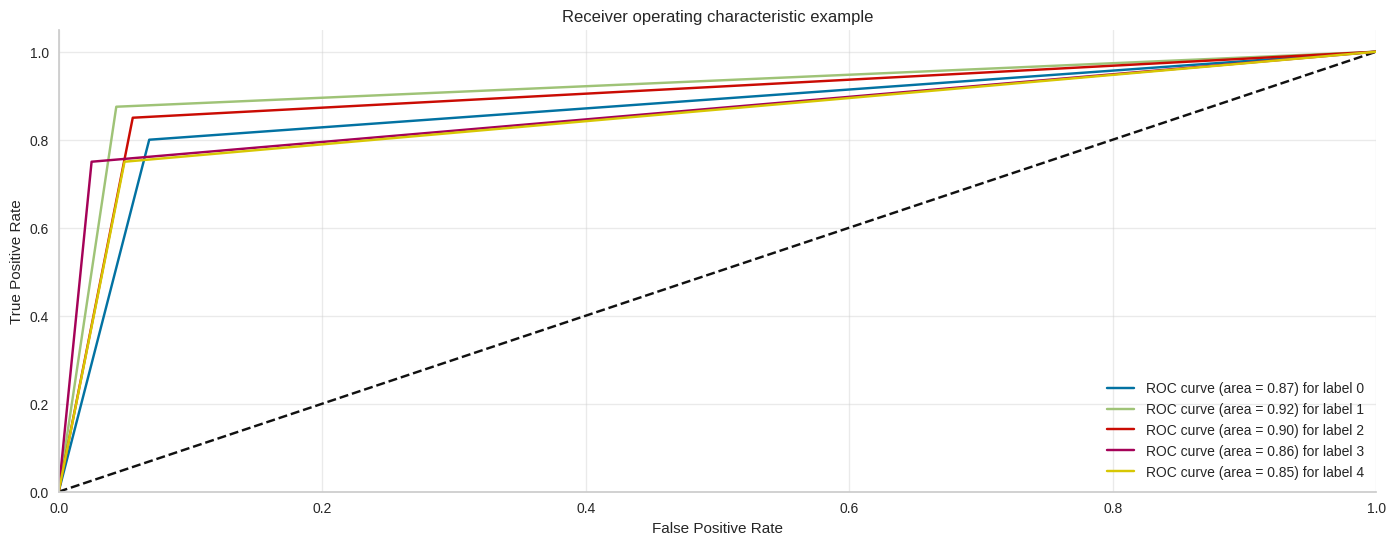

 
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        40
           1       0.83      0.88      0.85        40
           2       0.79      0.85      0.82        40
           3       0.88      0.75      0.81        40
           4       0.79      0.75      0.77        40

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.80       200
weighted avg       0.81      0.81      0.80       200

 
Cross Validation accuracy scores: [0.7625 0.7875 0.8125 0.5875 0.7375 0.85   0.8125 0.825  0.775  0.85  ]
Cross Validation accuracy: 0.780 +/- 0.073
k-Nearest Neighbor Accuracy: 0.795
 


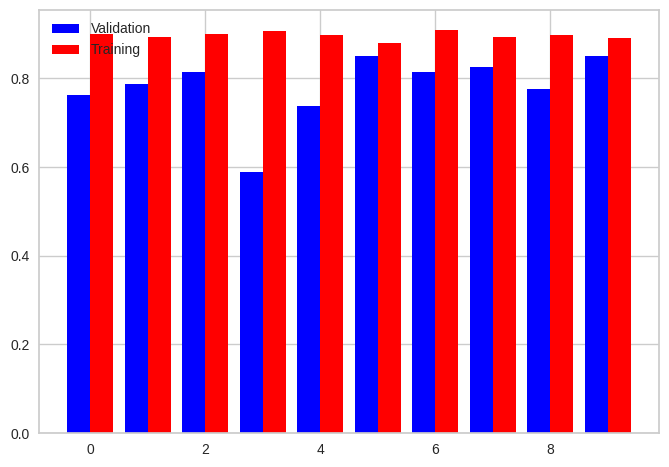

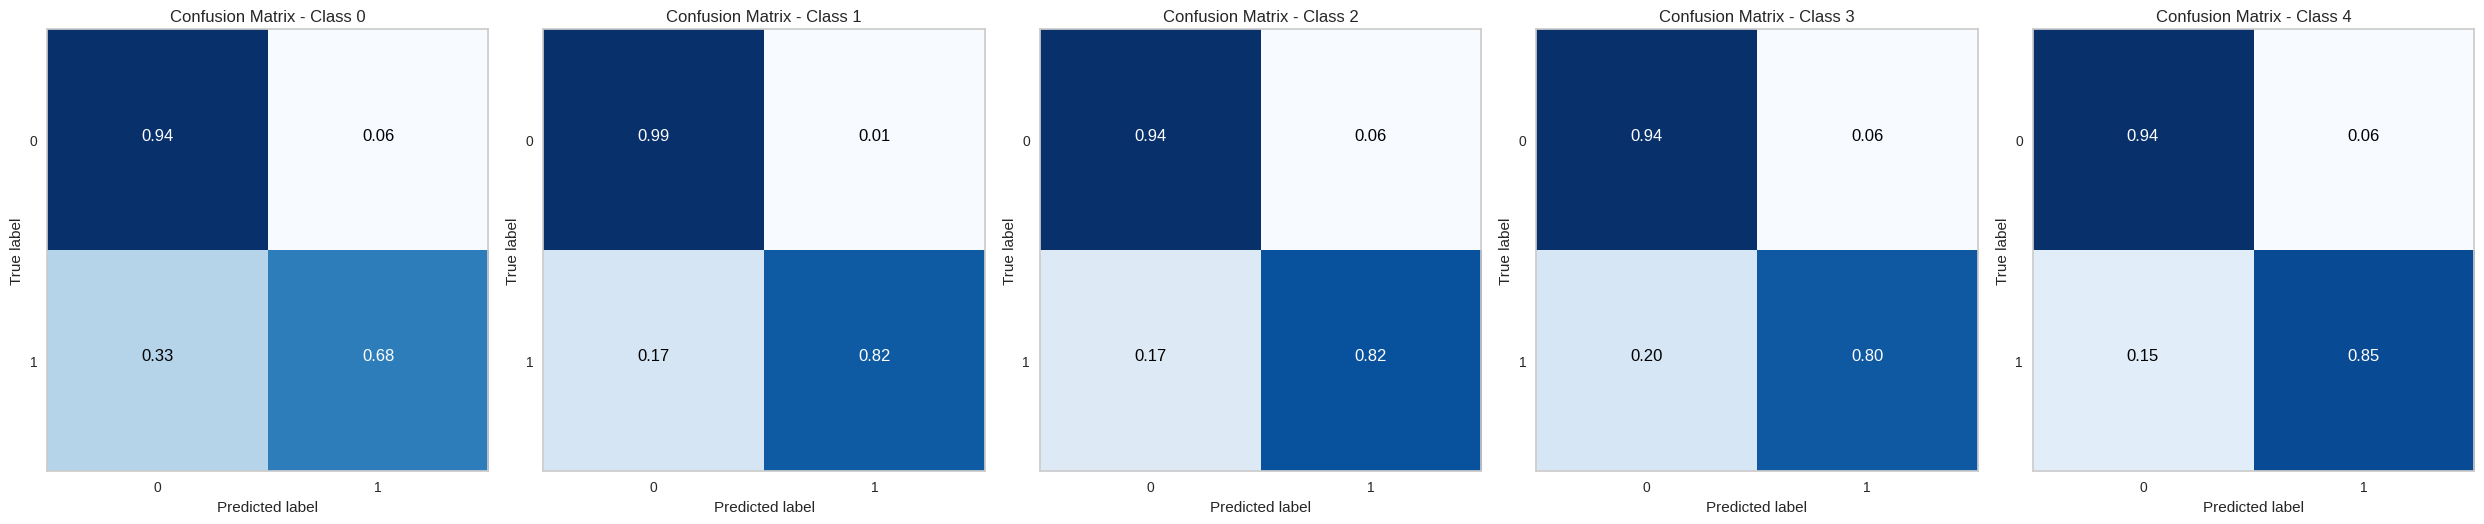

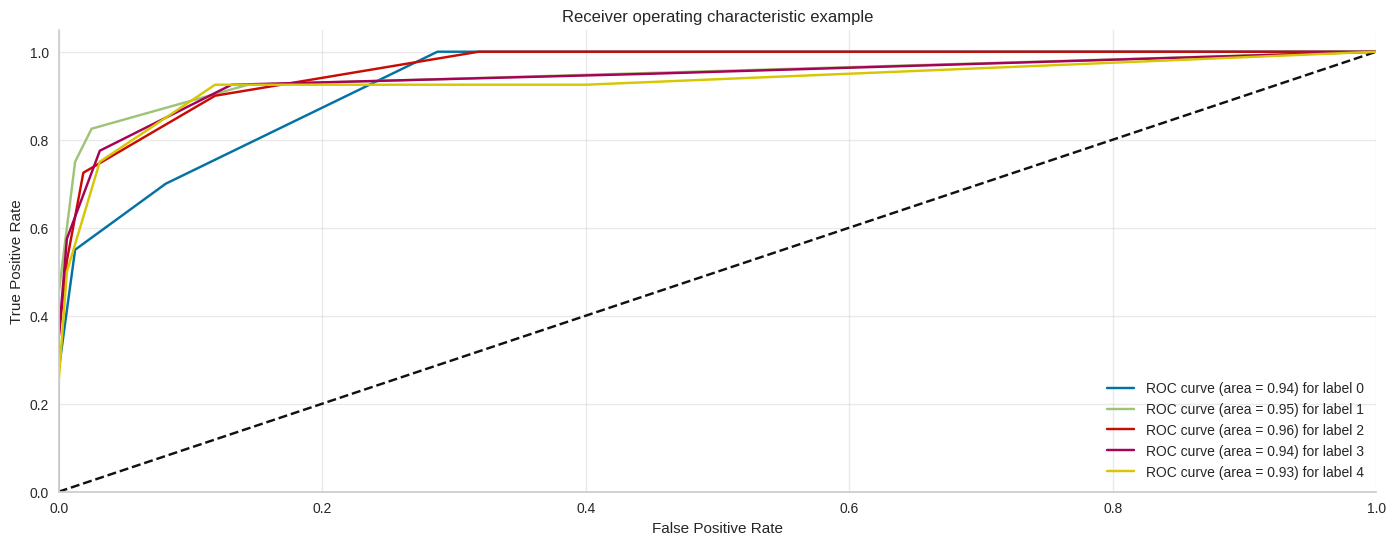

 
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70        40
           1       0.94      0.82      0.88        40
           2       0.77      0.82      0.80        40
           3       0.76      0.80      0.78        40
           4       0.79      0.85      0.82        40

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200

 
Cross Validation accuracy scores: [0.8    0.875  0.8    0.725  0.875  0.9125 0.925  0.85   0.8875 0.875 ]
Cross Validation accuracy: 0.853 +/- 0.058
XG-Boost Accuracy: 0.84
 


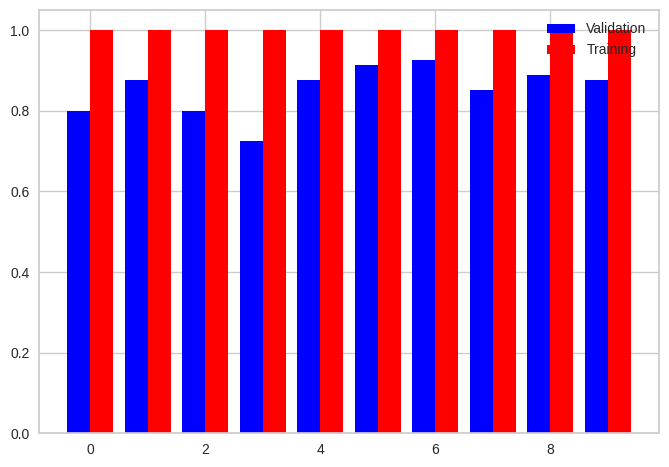

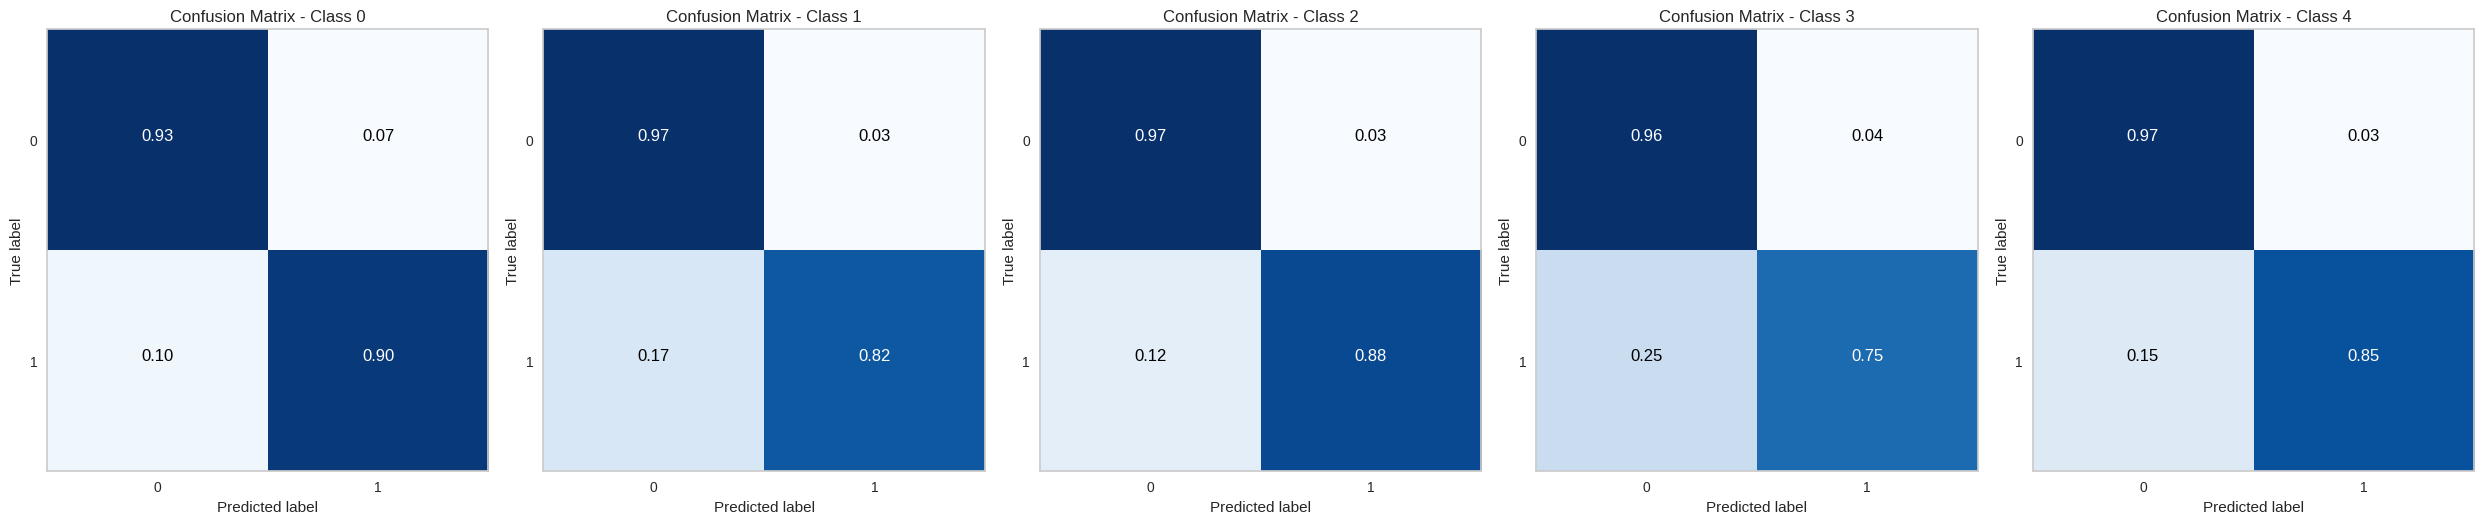

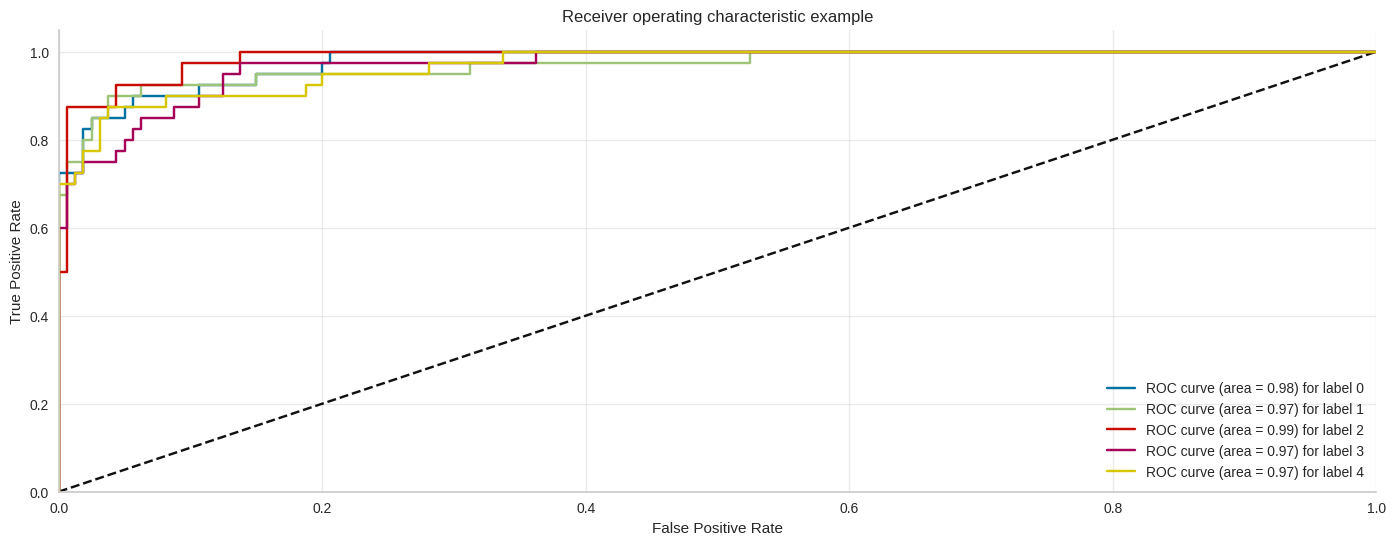

 
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        40
           1       0.87      0.82      0.85        40
           2       0.88      0.88      0.88        40
           3       0.83      0.75      0.79        40
           4       0.87      0.85      0.86        40

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200

 
Cross Validation accuracy scores: [0.9375 0.9125 0.9375 0.8375 0.925  0.9375 0.975  0.95   0.9125 0.9625]
Cross Validation accuracy: 0.929 +/- 0.036
Logistic Regression Accuracy: 0.91
 


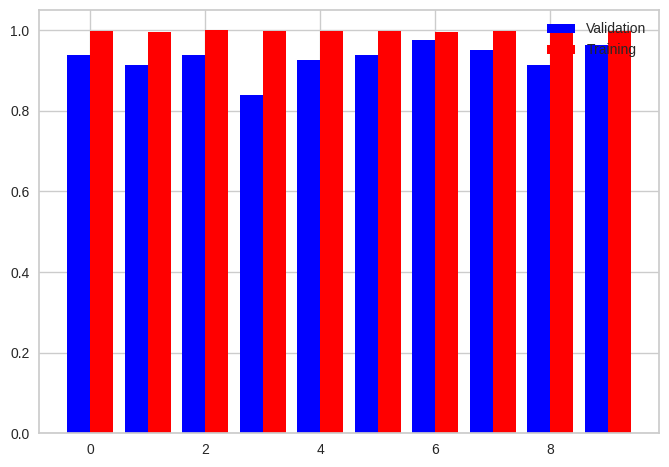

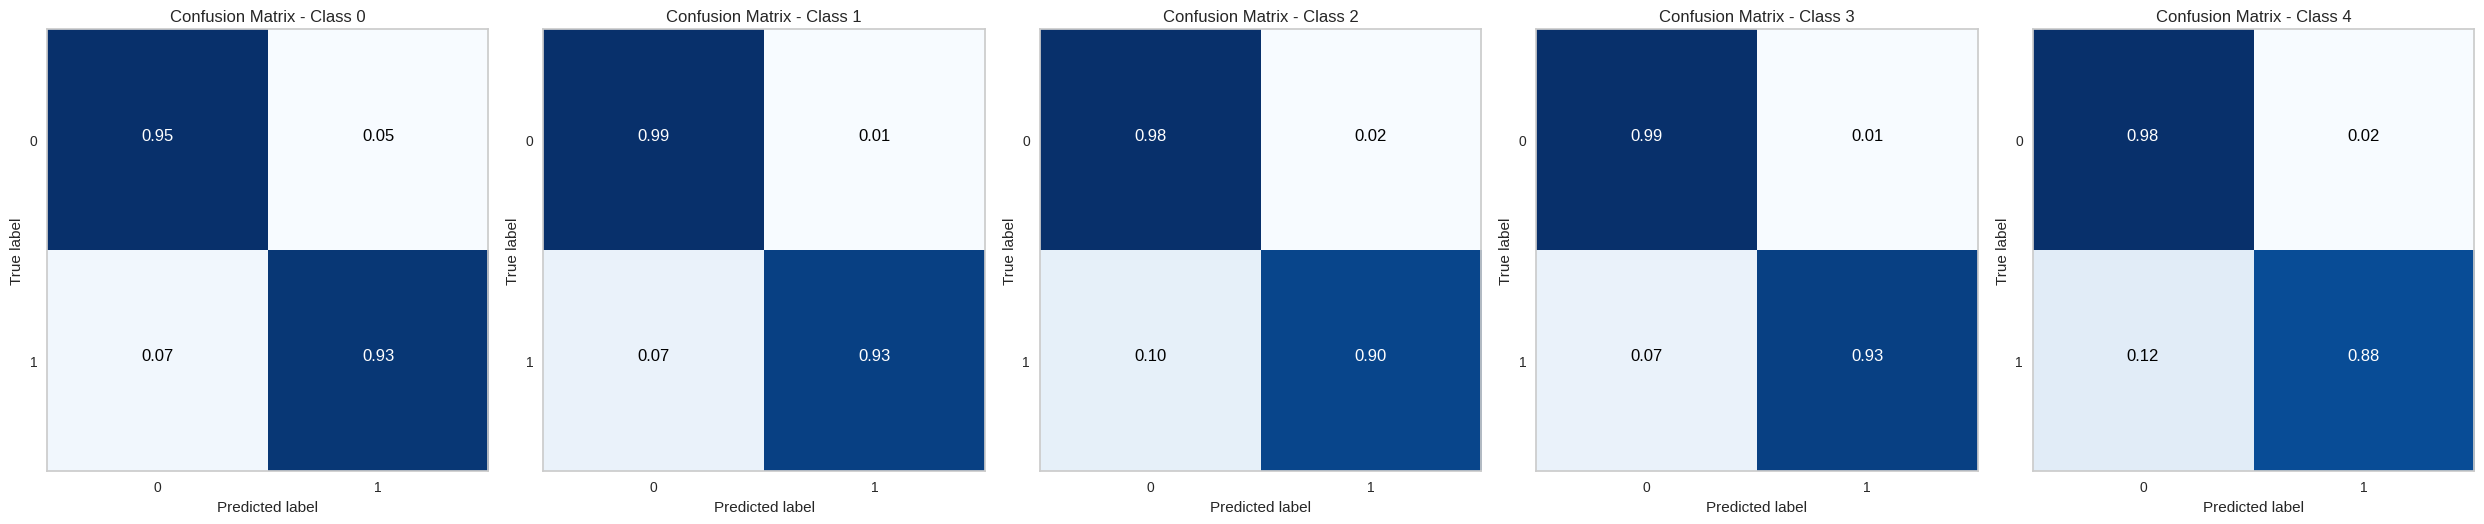

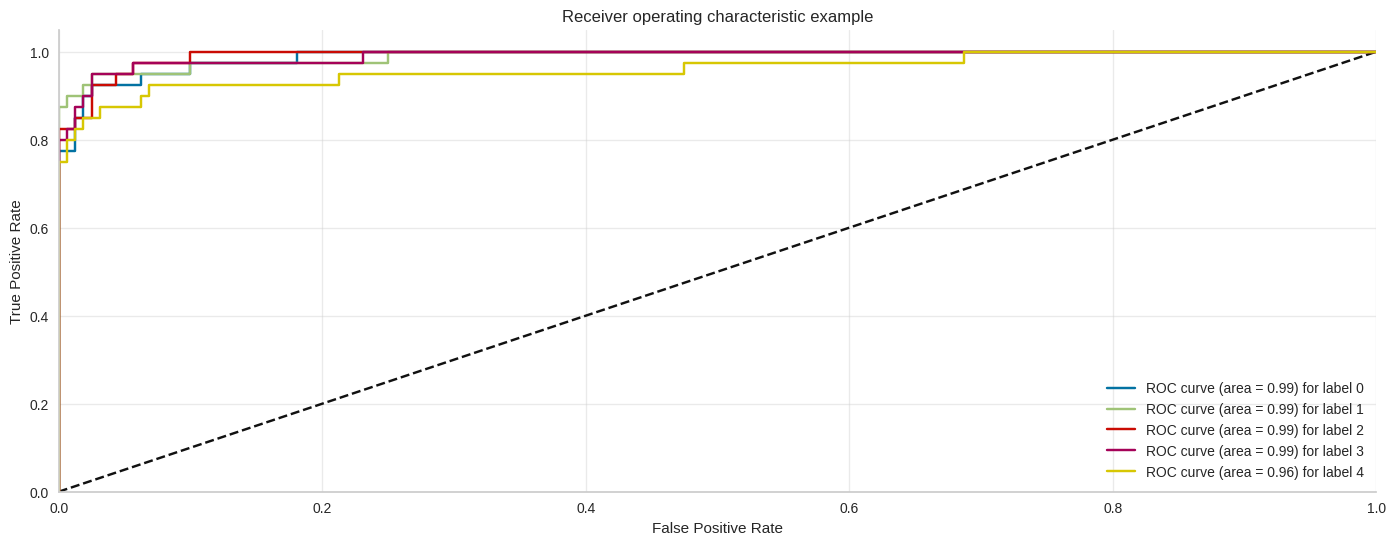

 
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        40
           1       0.95      0.93      0.94        40
           2       0.92      0.90      0.91        40
           3       0.95      0.93      0.94        40
           4       0.92      0.88      0.90        40

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

 
Best Model: Logistic Regression with Accuracy: 0.91


In [29]:
Transformed_Data = TFIDF()
train_and_evaluate_models(Transformed_Data, labels)

Cross Validation accuracy scores: [0.45   0.5375 0.5    0.4    0.4625 0.6125 0.55   0.5875 0.475  0.375 ]
Cross Validation accuracy: 0.495 +/- 0.074
SVM Accuracy: 0.56
 


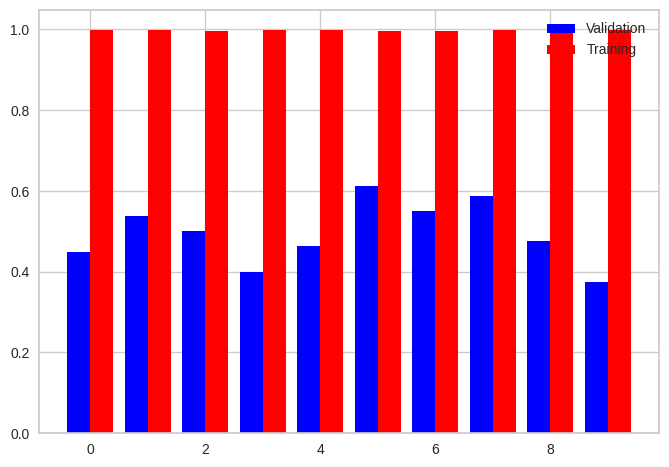

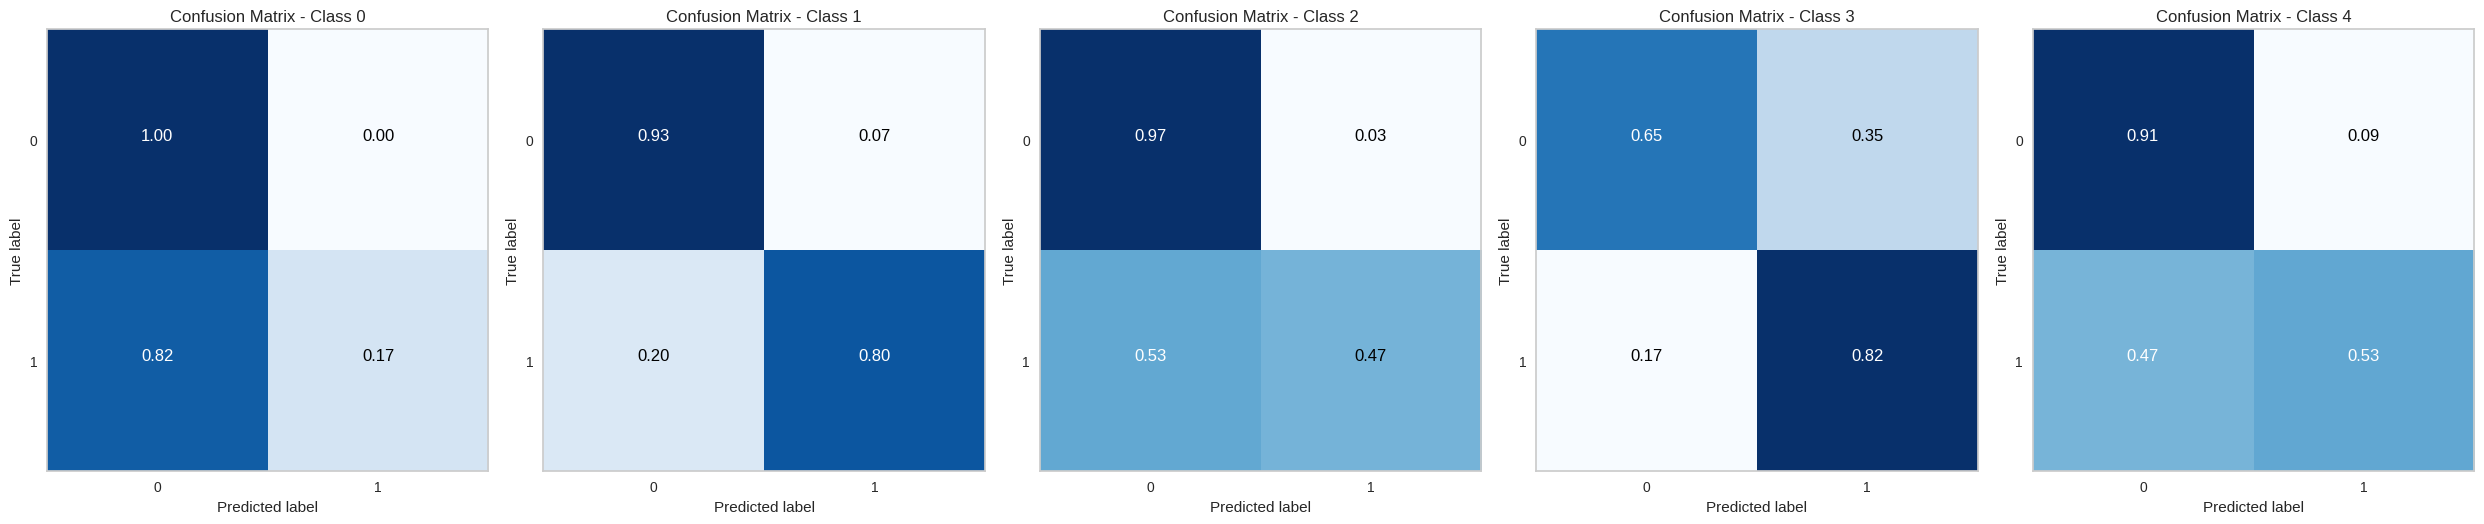

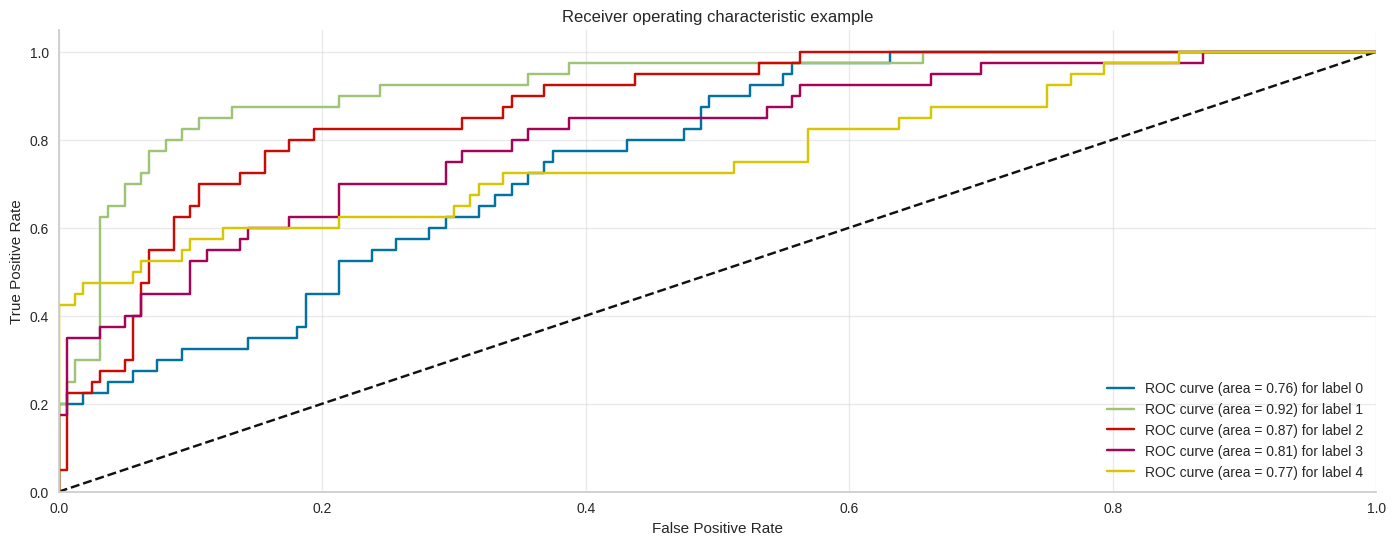

 
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.30        40
           1       0.73      0.80      0.76        40
           2       0.79      0.47      0.59        40
           3       0.37      0.82      0.51        40
           4       0.58      0.53      0.55        40

    accuracy                           0.56       200
   macro avg       0.69      0.56      0.54       200
weighted avg       0.69      0.56      0.54       200

 
Cross Validation accuracy scores: [0.3875 0.375  0.425  0.3875 0.4125 0.45   0.575  0.3125 0.425  0.425 ]
Cross Validation accuracy: 0.417 +/- 0.064
Random Forest Accuracy: 0.43
 


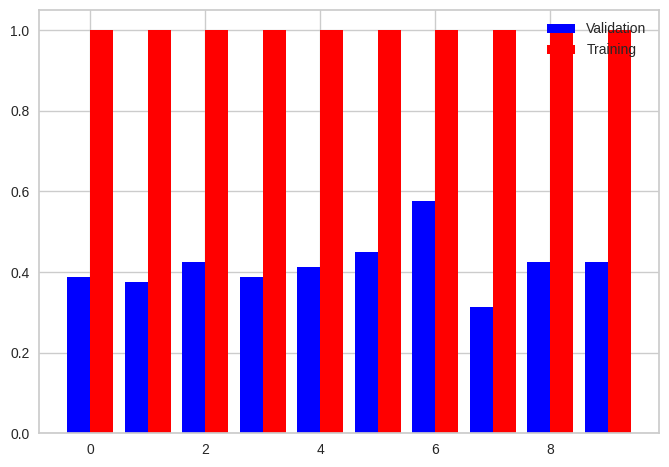

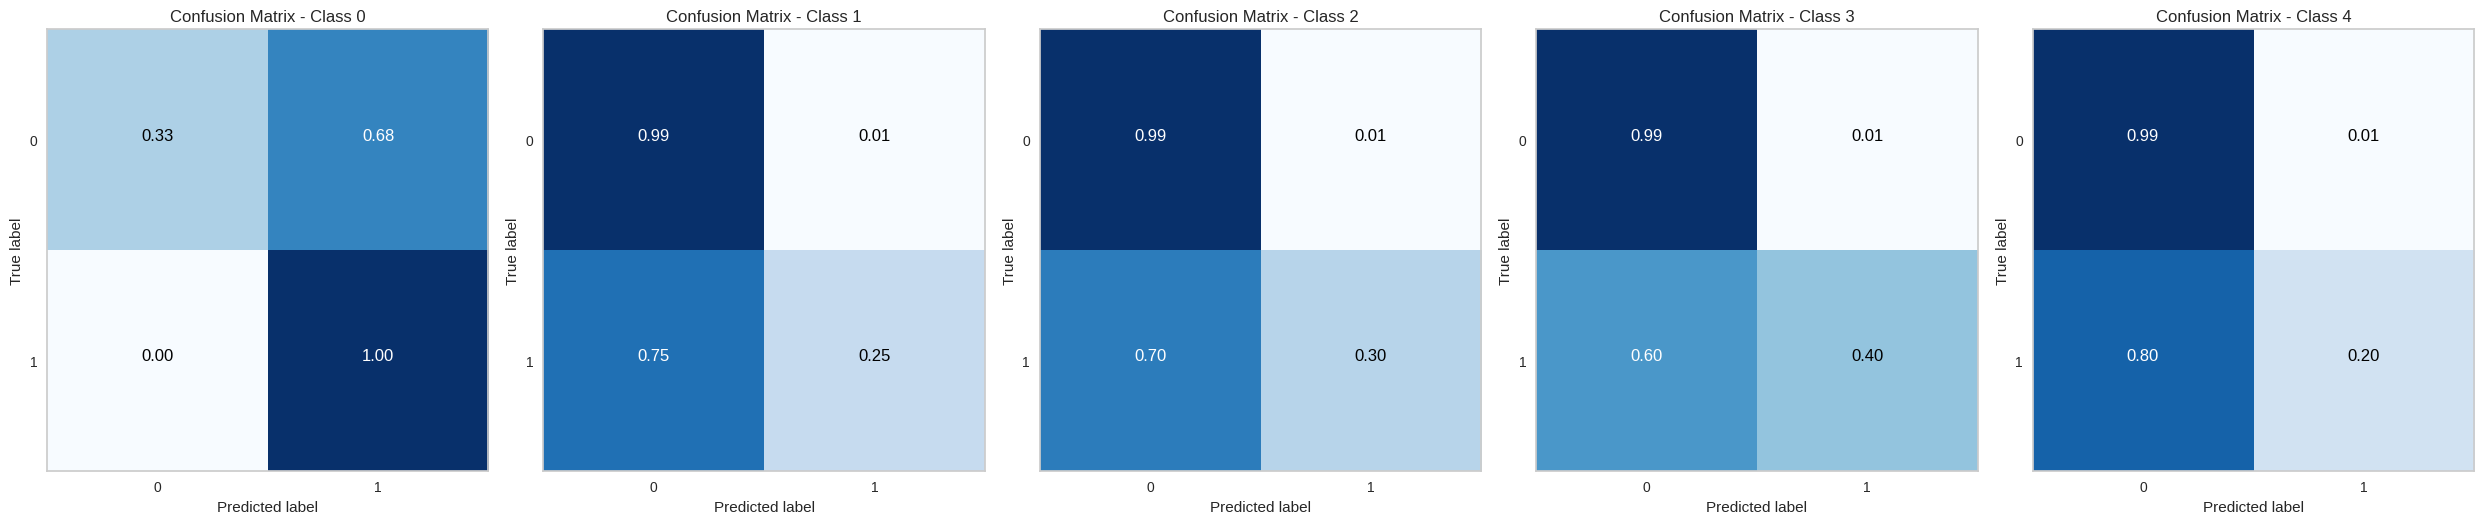

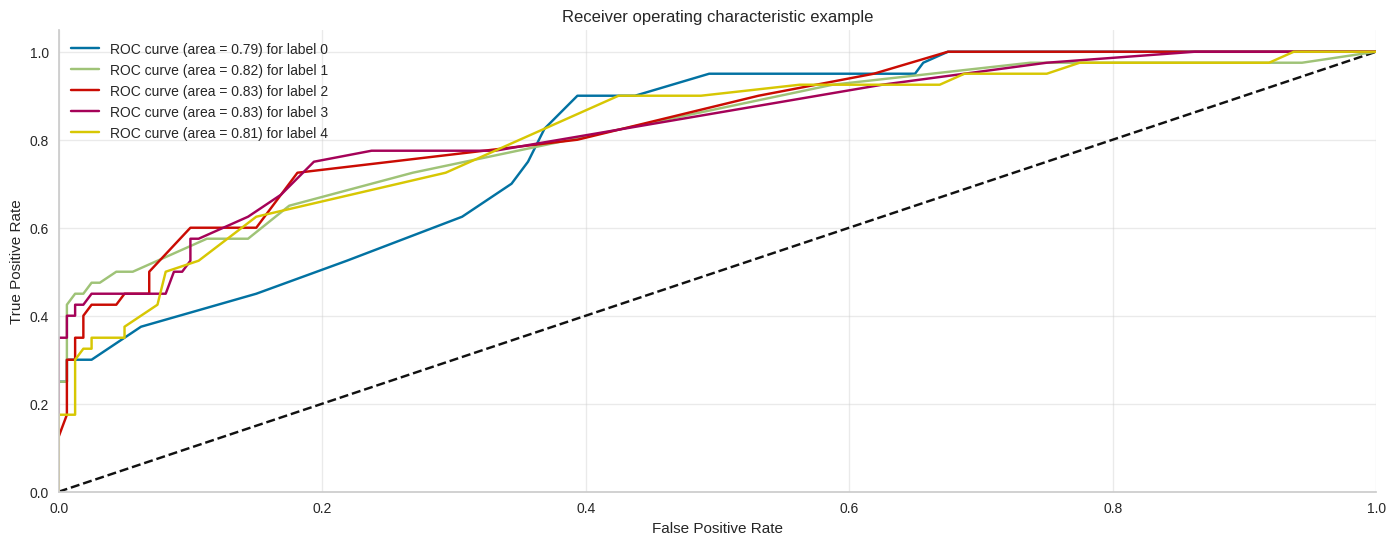

 
Classification Report:
              precision    recall  f1-score   support

           0       0.27      1.00      0.43        40
           1       0.91      0.25      0.39        40
           2       0.86      0.30      0.44        40
           3       0.94      0.40      0.56        40
           4       0.80      0.20      0.32        40

    accuracy                           0.43       200
   macro avg       0.76      0.43      0.43       200
weighted avg       0.76      0.43      0.43       200

 
Cross Validation accuracy scores: [0.6125 0.6125 0.6625 0.6625 0.675  0.7125 0.7    0.75   0.675  0.5875]
Cross Validation accuracy: 0.665 +/- 0.047
Naïve Bayes Accuracy: 0.64
 


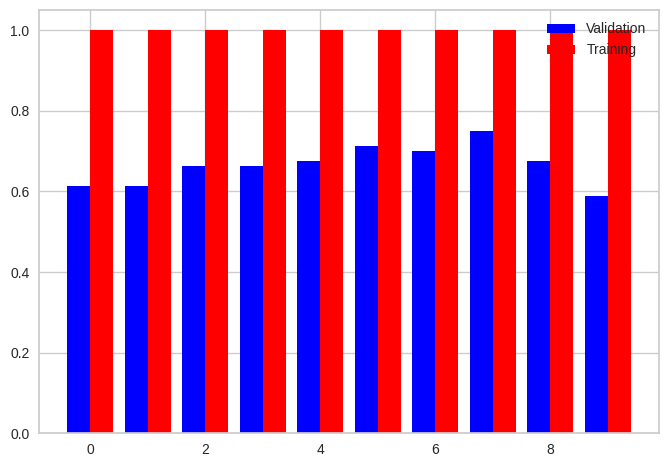

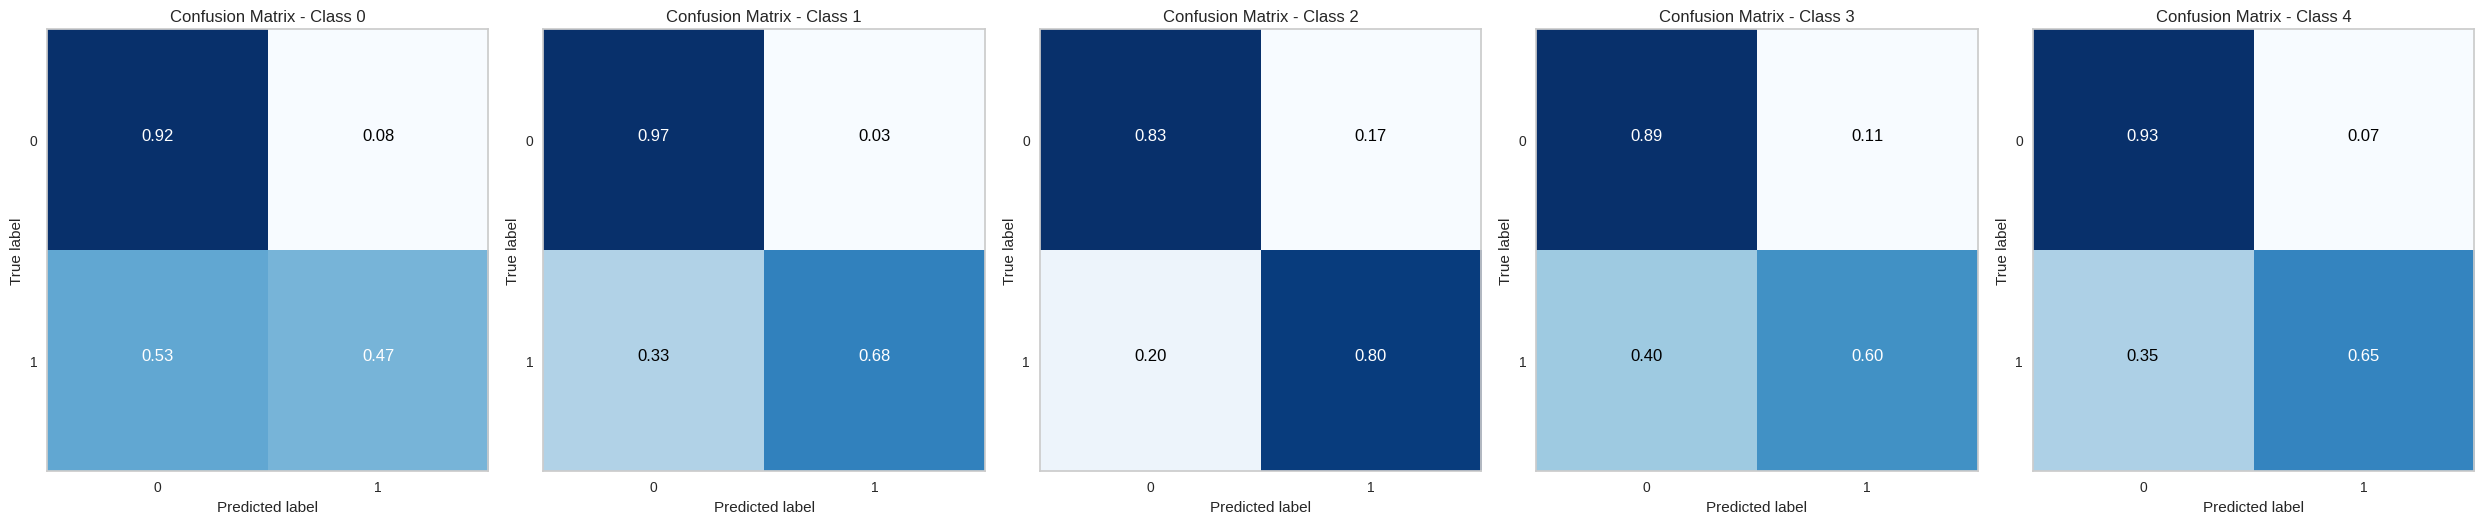

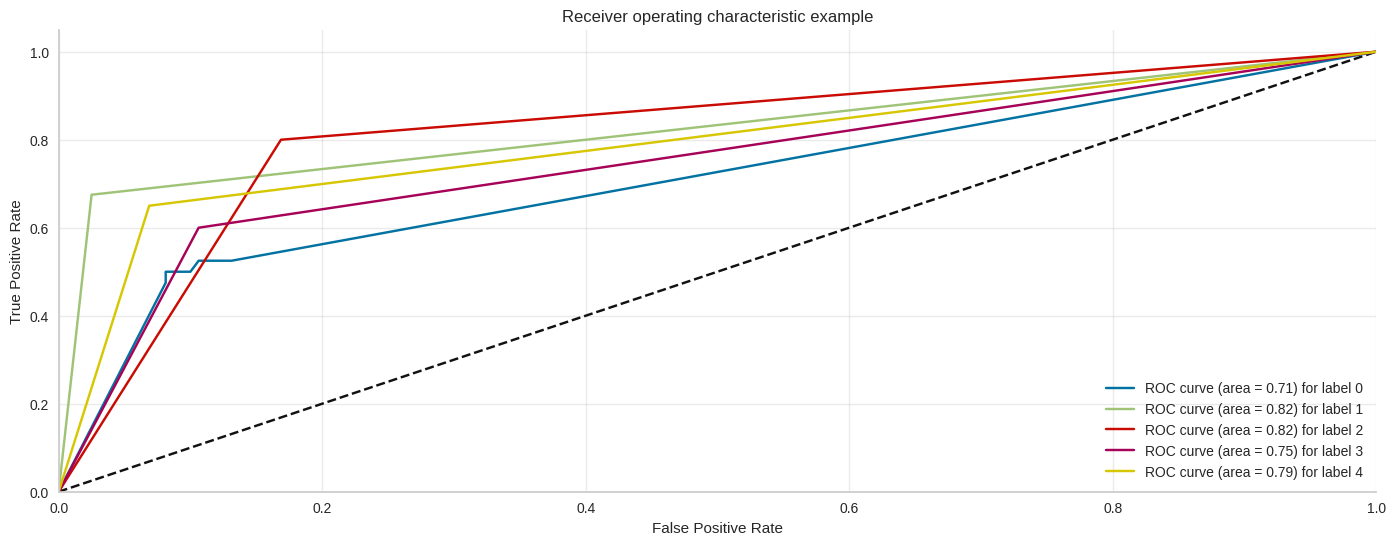

 
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.47      0.53        40
           1       0.87      0.68      0.76        40
           2       0.54      0.80      0.65        40
           3       0.59      0.60      0.59        40
           4       0.70      0.65      0.68        40

    accuracy                           0.64       200
   macro avg       0.66      0.64      0.64       200
weighted avg       0.66      0.64      0.64       200

 
Cross Validation accuracy scores: [0.275  0.25   0.2125 0.2    0.1625 0.275  0.2625 0.2125 0.35   0.2375]
Cross Validation accuracy: 0.244 +/- 0.049
k-Nearest Neighbor Accuracy: 0.225
 


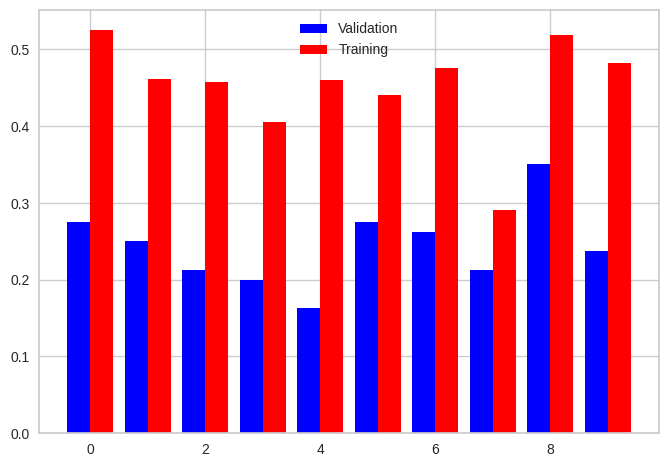

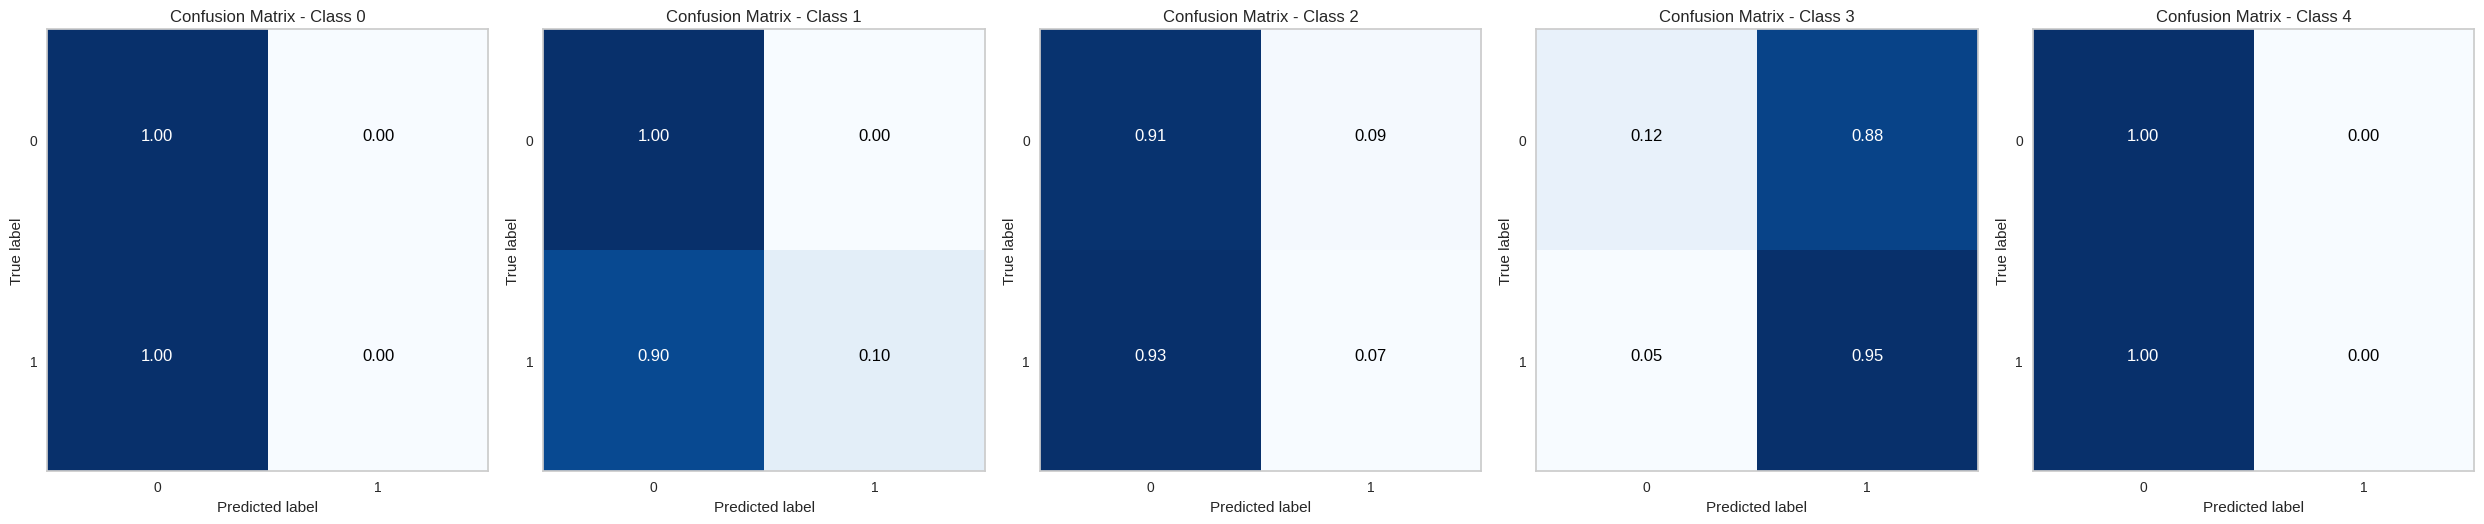

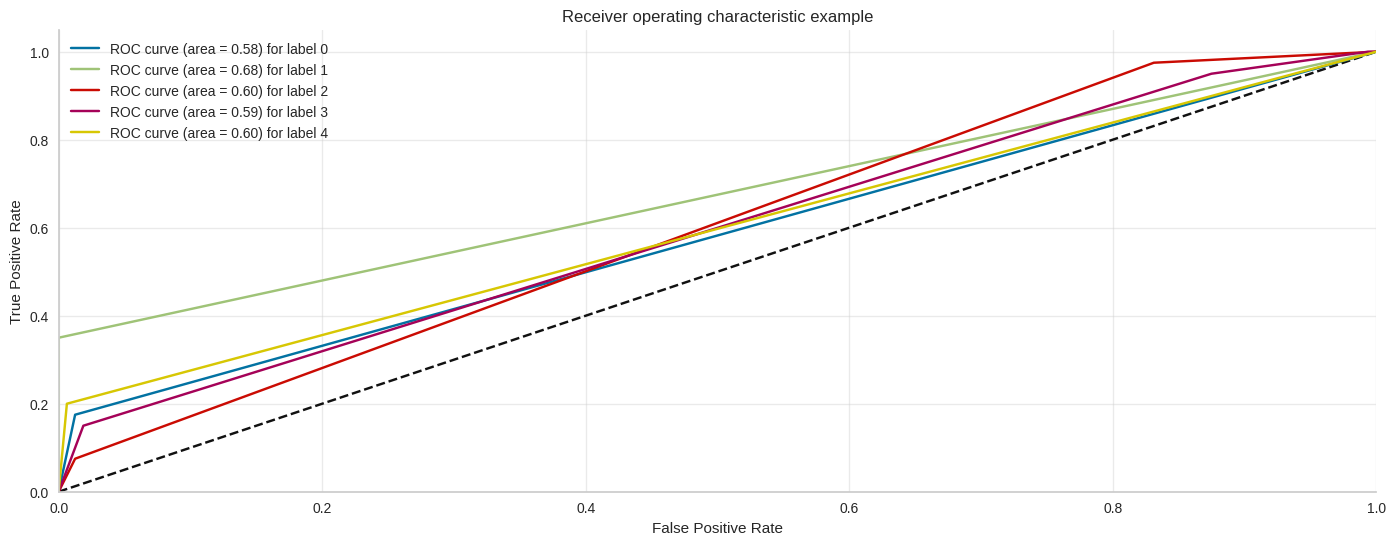

 
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       1.00      0.10      0.18        40
           2       0.18      0.07      0.11        40
           3       0.21      0.95      0.35        40
           4       0.00      0.00      0.00        40

    accuracy                           0.23       200
   macro avg       0.28      0.23      0.13       200
weighted avg       0.28      0.23      0.13       200

 
Cross Validation accuracy scores: [0.35   0.35   0.35   0.3875 0.3375 0.325  0.3875 0.3125 0.4    0.375 ]
Cross Validation accuracy: 0.357 +/- 0.028
XG-Boost Accuracy: 0.45
 


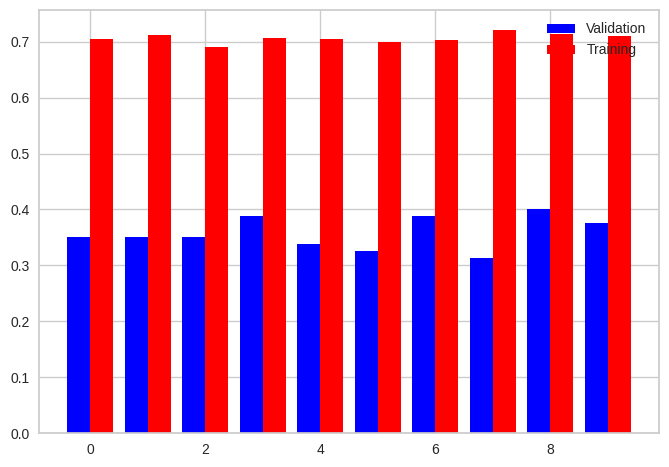

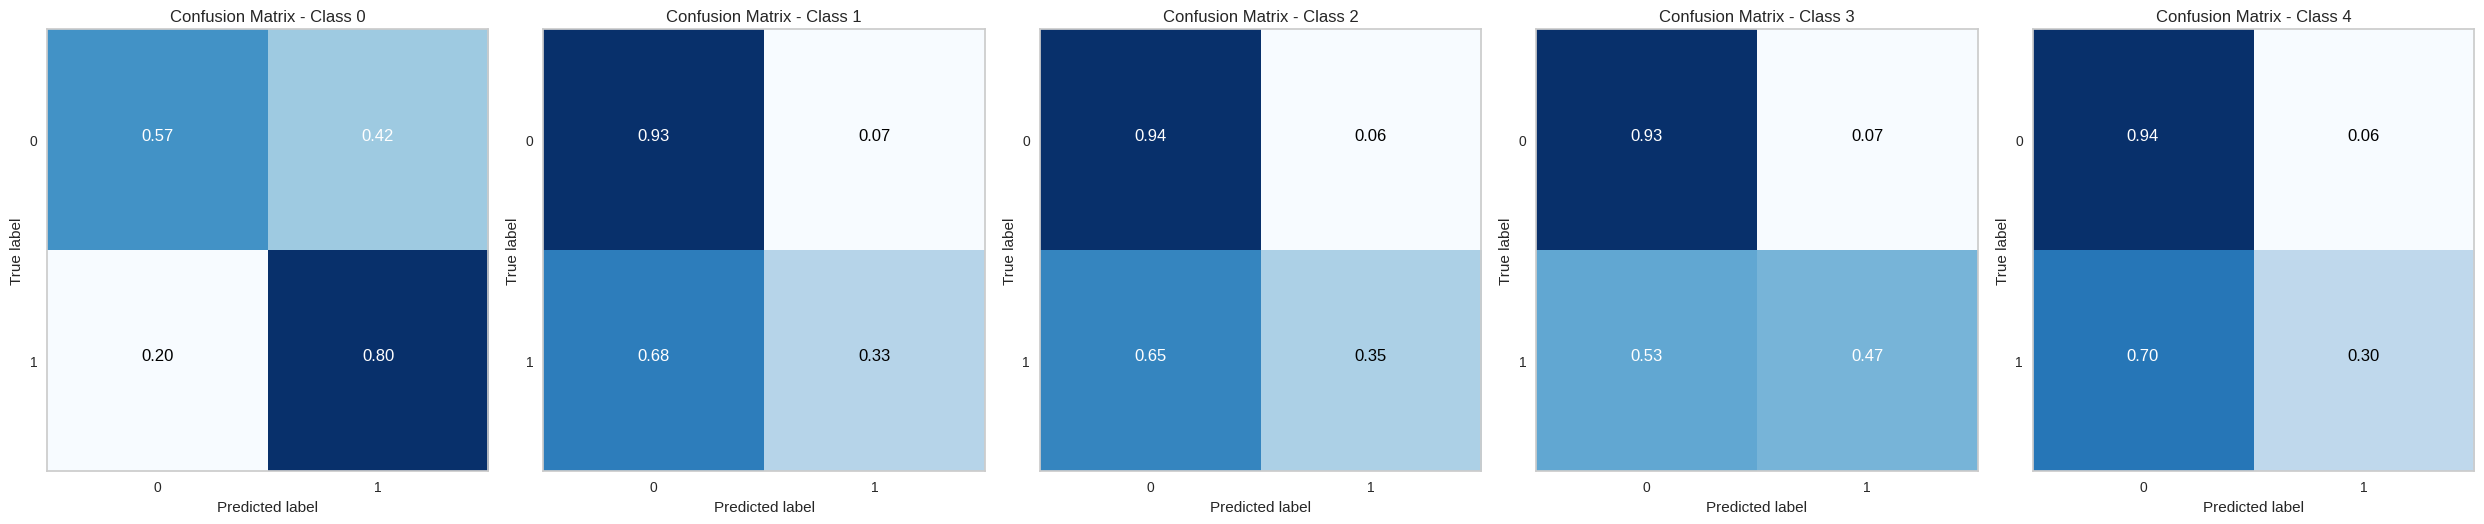

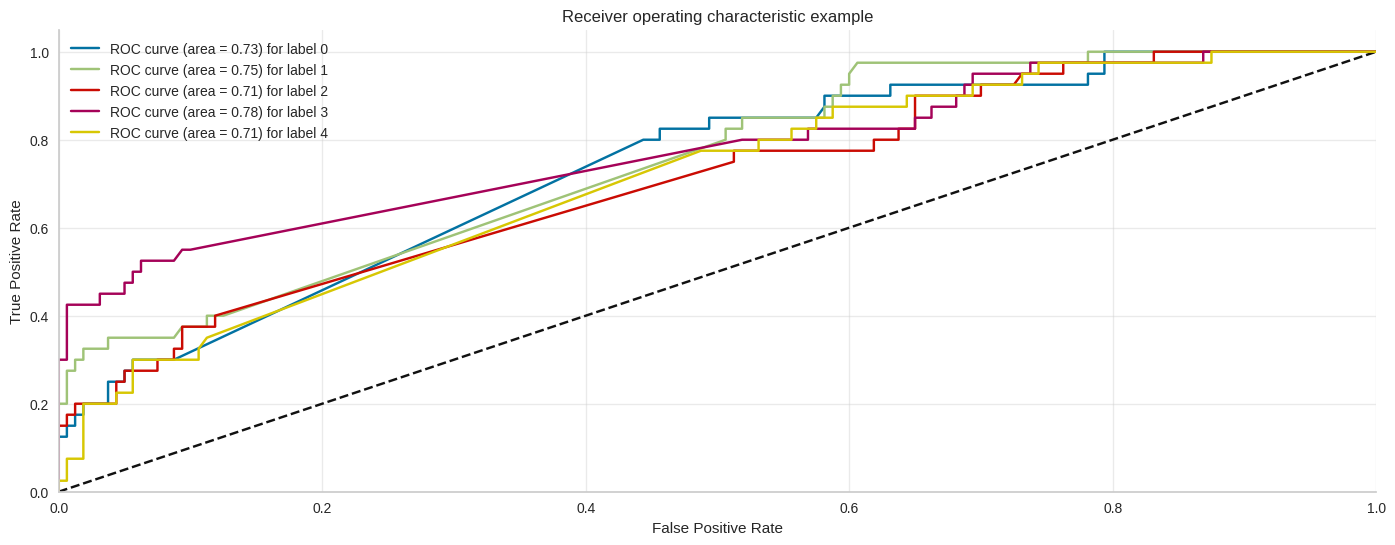

 
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.80      0.46        40
           1       0.54      0.33      0.41        40
           2       0.58      0.35      0.44        40
           3       0.63      0.47      0.54        40
           4       0.55      0.30      0.39        40

    accuracy                           0.45       200
   macro avg       0.52      0.45      0.45       200
weighted avg       0.52      0.45      0.45       200

 
Cross Validation accuracy scores: [0.5875 0.6375 0.6375 0.575  0.6625 0.675  0.65   0.6375 0.6    0.5   ]
Cross Validation accuracy: 0.616 +/- 0.049
Logistic Regression Accuracy: 0.595
 


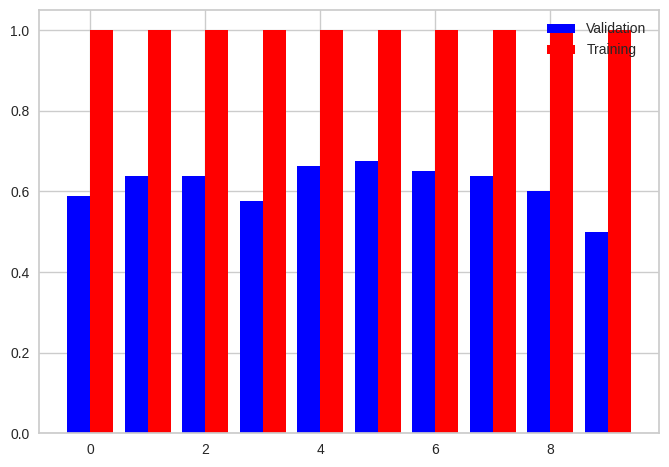

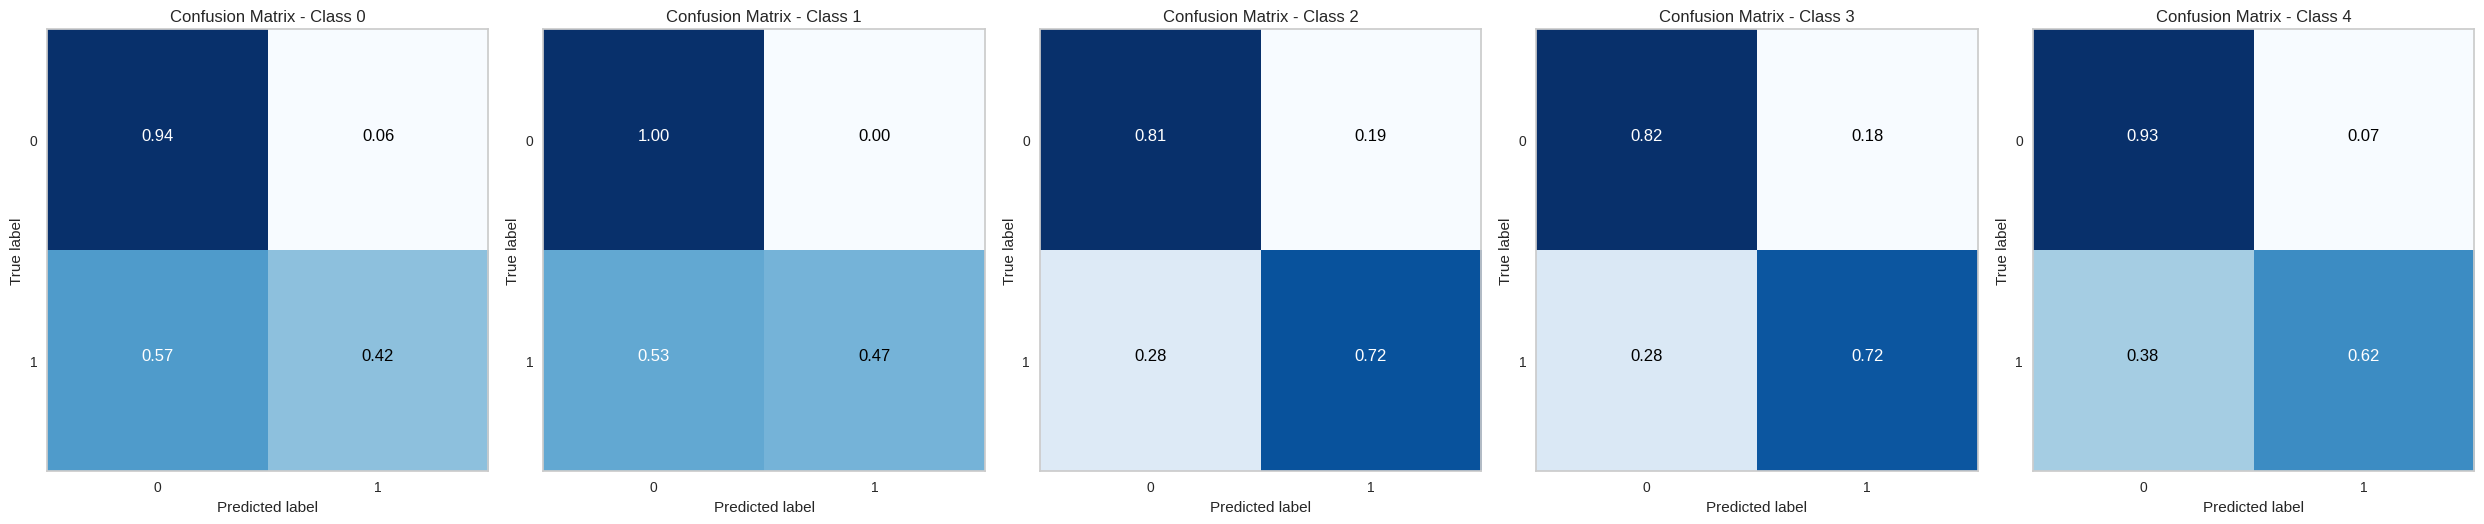

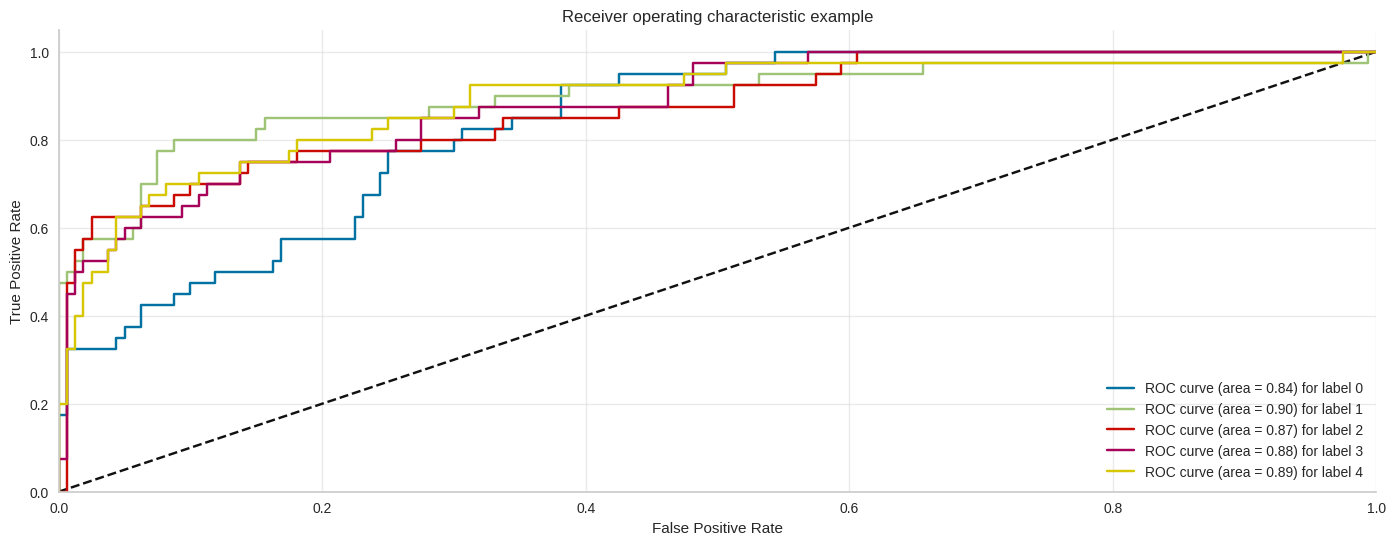

 
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.42      0.51        40
           1       1.00      0.47      0.64        40
           2       0.48      0.72      0.58        40
           3       0.50      0.72      0.59        40
           4       0.69      0.62      0.66        40

    accuracy                           0.59       200
   macro avg       0.66      0.59      0.60       200
weighted avg       0.66      0.59      0.60       200

 
Best Model: Naïve Bayes with Accuracy: 0.64


In [30]:
Transformed_Data = Ngram()
train_and_evaluate_models(Transformed_Data, labels)